# Experiment 1: Prompt Enhancement with Genetic Algorithms

## Goal
Evolve a basic prompt into an enhanced prompt using genetic algorithms.

## Methodology
- **Genome**: PromptGenome (base_prompt + positive_modifiers + negative_modifiers)
- **Fitness**: w1 * CLIP_score + w2 * Aesthetic_score
- **Model**: flux-schnell (Fal AI)

## Sub-experiments
- **1.1 Static Weights**: Fixed CLIP=0.6, Aesthetic=0.4 throughout evolution
- **1.2 Adaptive Weights**: CLIP weight decreases from 0.8 → 0.4 over generations

---

## Cell 1: Setup & Imports

In [1]:
# Standard library imports
import sys
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Add parent directory to path for src imports
sys.path.insert(0, '..')

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import scipy.stats as stats

# Project imports
from src.genome import PromptGenome, GenomeFactory
from src.evolution import GeneticOperators, EvolutionEngine
from src.fitness import FitnessEvaluator, AdaptiveFitnessEvaluator
from src.models import get_model
from src.vocabulary_manager import VocabularyManager
from src.utils import (
    create_modifier_vocab, 
    create_negative_vocab, 
    save_json,
    Logger
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Enable inline plotting
%matplotlib inline

print("Environment setup complete.")
print(f"Random seed: {RANDOM_SEED}")
print(f"Working directory: {os.getcwd()}")

Environment setup complete.
Random seed: 42
Working directory: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/experiments


## Cell 2: Configuration

In [2]:
# =============================================================================
# EXPERIMENT PARAMETERS (ENHANCED)
# =============================================================================

# Base prompt to evolve
BASE_PROMPT = "a tiger in the jungle"

# Evolution parameters - INCREASED for better results
POPULATION_SIZE = 20
MAX_GENERATIONS = 150

# Vocabulary Manager parameters
USE_VOCABULARY_MANAGER = True  # Enable LLM-based adaptive vocabulary
VOCAB_INITIAL_SIZE = 1000  # Target size for initial vocabulary
VOCAB_EXPANSION_SIZE = 50  # New modifiers to add per expansion
VOCAB_PRUNE_THRESHOLD = 20  # Generations before pruning unused modifiers
VOCAB_EXPANSION_INTERVAL = 5  # Expand vocabulary every N generations
VOCAB_PRUNE_INTERVAL = 10  # Prune vocabulary every N generations
ELITE_SIZE = 2
MUTATION_RATE = 0.5
ADD_PROBABILITY = 0.35
REMOVE_PROBABILITY = 0.2

# Genome constraints - EXPANDED search space
MAX_POSITIVE_MODIFIERS = 12
MAX_NEGATIVE_MODIFIERS = 6

# =============================================================================
# FITNESS WEIGHTS
# =============================================================================

# Static weights (Experiment 1.1)
STATIC_CLIP_WEIGHT = 0.6
STATIC_AESTHETIC_WEIGHT = 0.4

# Adaptive weights (Experiment 1.2)
# Strategy: Start with semantic alignment, shift to aesthetic focus
INITIAL_CLIP_WEIGHT = 0.8  # Early: prioritize CLIP (semantic alignment)
FINAL_CLIP_WEIGHT = 0.4    # Late: prioritize aesthetics

# =============================================================================
# MODEL SETTINGS
# =============================================================================

MODEL_NAME = "flux-schnell"
IMAGE_SIZE = "landscape_4_3"
NUM_INFERENCE_STEPS = 4
GENERATION_SEED = 42  # Fixed seed for reproducible image generation

# =============================================================================
# OUTPUT SETTINGS
# =============================================================================

OUTPUT_DIR = Path("../data/results/experiment_1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_EVERY_N_GENERATIONS = 5  # Save checkpoints every N generations
SAVE_ALL_IMAGES = True  # NEW: Save all generated images

# =============================================================================
# RESULTS TRACKING
# =============================================================================

# Global array to store all results
ALL_RESULTS = []

# Print configuration summary
print("=" * 60)
print("EXPERIMENT 1 CONFIGURATION (ENHANCED)")
print("=" * 60)
print(f"\nBase Prompt: {BASE_PROMPT}")
print(f"\nEvolution Parameters:")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Max Generations: {MAX_GENERATIONS}")
print(f"  Elite Size: {ELITE_SIZE}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print(f"  Max Positive Modifiers: {MAX_POSITIVE_MODIFIERS}")
print(f"  Max Negative Modifiers: {MAX_NEGATIVE_MODIFIERS}")
print(f"\nStatic Weights (Exp 1.1):")
print(f"  CLIP: {STATIC_CLIP_WEIGHT}, Aesthetic: {STATIC_AESTHETIC_WEIGHT}")
print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  CLIP: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"\nModel: {MODEL_NAME}")
print(f"Save All Images: {SAVE_ALL_IMAGES}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 60)

EXPERIMENT 1 CONFIGURATION (ENHANCED)

Base Prompt: a tiger in the jungle

Evolution Parameters:
  Population Size: 20
  Max Generations: 150
  Elite Size: 2
  Mutation Rate: 0.5
  Max Positive Modifiers: 12
  Max Negative Modifiers: 6

Static Weights (Exp 1.1):
  CLIP: 0.6, Aesthetic: 0.4

Adaptive Weights (Exp 1.2):
  CLIP: 0.8 -> 0.4

Model: flux-schnell
Save All Images: True
Output Directory: ../data/results/experiment_1


## Cell 3: Initialize Components

In [3]:
# =============================================================================
# INITIALIZE MODEL
# =============================================================================
print("Initializing image generation model...")
model = get_model(MODEL_NAME)
print(f"  Model: {MODEL_NAME} initialized")

# =============================================================================
# CREATE VOCABULARIES
# =============================================================================
print("\nCreating vocabularies...")

# Initialize VocabularyManager if enabled
vocab_manager = None
if USE_VOCABULARY_MANAGER:
    print("\nInitializing VocabularyManager with LLM...")
    vocab_manager = VocabularyManager(
        use_llm=True,
        initial_size=VOCAB_INITIAL_SIZE,
        expansion_size=VOCAB_EXPANSION_SIZE,
        prune_threshold=VOCAB_PRUNE_THRESHOLD
    )
    
    # Initialize vocabulary with domain description
    domain_description = f"image generation for: {BASE_PROMPT}"
    block_vocabularies = vocab_manager.initialize_vocabulary(
        reference_image=None,
        domain_description=domain_description
    )
    
    # Convert block vocabularies to flat lists for Experiment 1
    # Combine all positive blocks into one list
    modifier_vocab = []
    for block_name in ["composition", "lighting", "style", "quality"]:
        modifier_vocab.extend(block_vocabularies.get(block_name, []))
    
    negative_vocab = block_vocabularies.get("negative", [])
    
    print(f"\n  LLM-generated vocabulary:")
    print(f"  Positive modifiers: {len(modifier_vocab)} terms")
    print(f"  Negative modifiers: {len(negative_vocab)} terms")
    print(f"  Synonym mappings: {len(vocab_manager.synonym_map)}")
else:
    # Fallback to static vocabulary
    modifier_vocab = create_modifier_vocab()
    negative_vocab = create_negative_vocab()
    print(f"  Static vocabulary:")
    print(f"  Positive modifiers: {len(modifier_vocab)} terms")
    print(f"  Negative modifiers: {len(negative_vocab)} terms")

# Preview some modifiers
print(f"\n  Sample positive modifiers: {modifier_vocab[:5]}")
print(f"  Sample negative modifiers: {negative_vocab[:5]}")

# =============================================================================
# CREATE GENOME FACTORY
# =============================================================================
print("\nCreating genome factory...")
factory = GenomeFactory(
    modifier_vocab=modifier_vocab,
    negative_vocab=negative_vocab,
    max_positive_modifiers=MAX_POSITIVE_MODIFIERS,
    max_negative_modifiers=MAX_NEGATIVE_MODIFIERS
)
print(f"  Max positive modifiers: {MAX_POSITIVE_MODIFIERS}")
print(f"  Max negative modifiers: {MAX_NEGATIVE_MODIFIERS}")

# =============================================================================
# CREATE GENETIC OPERATORS
# =============================================================================
print("\nCreating genetic operators...")
operators = GeneticOperators(
    factory=factory,
    vocabulary_manager=vocab_manager,  # Enable synonym-aware mutation
    mutation_rate=MUTATION_RATE,
    add_probability=ADD_PROBABILITY,
    remove_probability=REMOVE_PROBABILITY
)
print(f"  Mutation rate: {MUTATION_RATE}")
print(f"  Add probability: {ADD_PROBABILITY}")
print(f"  Remove probability: {REMOVE_PROBABILITY}")

# =============================================================================
# CREATE EVOLUTION ENGINE
# =============================================================================
print("\nCreating evolution engine...")
engine = EvolutionEngine(
    factory=factory,
    operators=operators,
    population_size=POPULATION_SIZE,
    elite_size=ELITE_SIZE,
    selection_method="tournament"
)
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Elite size: {ELITE_SIZE}")
print(f"  Selection method: tournament")

# =============================================================================
# CREATE FITNESS EVALUATORS
# =============================================================================
print("\nCreating fitness evaluators...")

# Static fitness evaluator (Experiment 1.1)
static_evaluator = FitnessEvaluator(
    clip_weight=STATIC_CLIP_WEIGHT,
    aesthetic_weight=STATIC_AESTHETIC_WEIGHT
)
print(f"  Static Evaluator: CLIP={STATIC_CLIP_WEIGHT}, Aesthetic={STATIC_AESTHETIC_WEIGHT}")

# Adaptive fitness evaluator (Experiment 1.2)
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)
print(f"  Adaptive Evaluator: CLIP {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")

# =============================================================================
# INITIALIZE LOGGER
# =============================================================================
logger = Logger(log_dir=str(OUTPUT_DIR / "logs"), name="experiment_1")
logger.info("Experiment 1 components initialized")

print("\n" + "=" * 60)
print("ALL COMPONENTS INITIALIZED SUCCESSFULLY")
print("=" * 60)

Initializing image generation model...
  Model: flux-schnell initialized

Creating vocabularies...

Initializing VocabularyManager with LLM...


/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


VocabularyManager: Initialized Gemini (project: hubx-ml-playground)

INITIALIZING VOCABULARY
Target size: 1000 modifiers
Domain: image generation for: a tiger in the jungle
LLM enabled: True
Generating vocabulary...

INITIAL VOCABULARY:
  composition :  176 modifiers
  lighting    :  171 modifiers
  style       :  180 modifiers
  quality     :  174 modifiers
  negative    :  158 modifiers
  TOTAL       :  859 modifiers
  Synonym mappings: 29


  LLM-generated vocabulary:
  Positive modifiers: 701 terms
  Negative modifiers: 158 terms
  Synonym mappings: 29

  Sample positive modifiers: ['wide shot', 'medium shot', 'close-up', 'extreme close-up', 'establishing shot']
  Sample negative modifiers: ['blurry', 'grainy', 'noisy', 'pixelated', 'low resolution']

Creating genome factory...
  Max positive modifiers: 12
  Max negative modifiers: 6

Creating genetic operators...
  Mutation rate: 0.5
  Add probability: 0.35
  Remove probability: 0.2

Creating evolution engine...
  Population size:

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully
  Static Evaluator: CLIP=0.6, Aesthetic=0.4
Initializing CLIP model on cpu...


2025-12-30 17:27:36,785 - experiment_1 - INFO - Experiment 1 components initialized


CLIP model loaded successfully
  Adaptive Evaluator: CLIP 0.8 -> 0.4

ALL COMPONENTS INITIALIZED SUCCESSFULLY


## Cell 4: Baseline Evaluation

Generating baseline image (no modifiers)...
Prompt: a tiger in the jungle

Baseline genome: PromptGenome(fitness=0.000, prompt='a tiger in the jungle')
Baseline image generated successfully.

Evaluating baseline fitness...
CLIP score: 0.6552
Aesthetic score: 0.7900
Weighted fitness: 0.7091

Baseline Fitness Score: 0.7091
Baseline image saved to: ../data/results/experiment_1/baseline_image.jpg


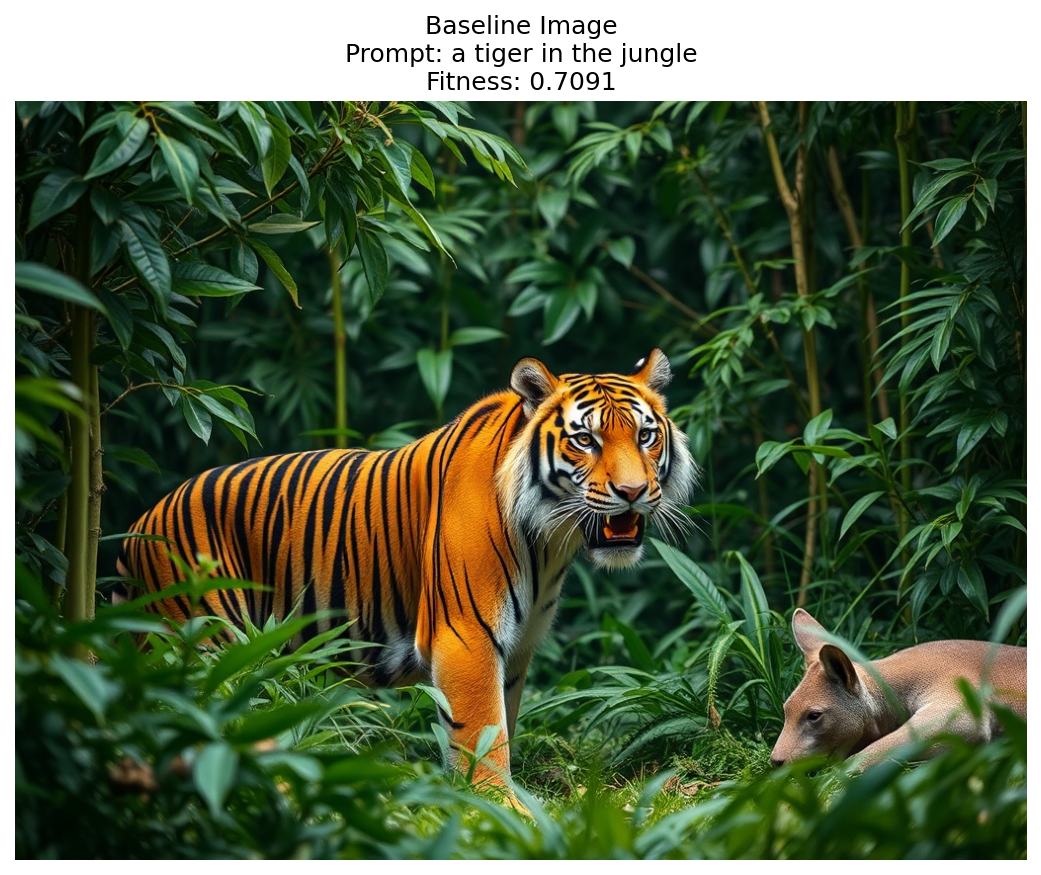

2025-12-30 17:28:31,939 - experiment_1 - INFO - Baseline evaluation complete. Score: 0.7091


In [4]:
# =============================================================================
# GENERATE AND EVALUATE BASELINE
# =============================================================================
print("Generating baseline image (no modifiers)...")
print(f"Prompt: {BASE_PROMPT}")
print()

# Create baseline genome (empty modifiers)
baseline_genome = factory.create_empty(BASE_PROMPT)
print(f"Baseline genome: {baseline_genome}")

# Generate baseline image
try:
    baseline_image, baseline_metadata = model.generate(
        prompt=baseline_genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=GENERATION_SEED
    )
    print("Baseline image generated successfully.")
except Exception as e:
    print(f"Error generating baseline image: {e}")
    raise

# Evaluate baseline fitness using static evaluator
print("\nEvaluating baseline fitness...")
baseline_score = static_evaluator.evaluate(
    image=baseline_image, 
    text=BASE_PROMPT, 
    verbose=True
)
print(f"\nBaseline Fitness Score: {baseline_score:.4f}")

# Save baseline image
baseline_path = OUTPUT_DIR / "baseline_image.jpg"
baseline_image.save(baseline_path)
print(f"Baseline image saved to: {baseline_path}")

# Display baseline image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(baseline_image)
ax.set_title(f"Baseline Image\nPrompt: {BASE_PROMPT}\nFitness: {baseline_score:.4f}", fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "baseline_display.png")
plt.show()

# Log baseline results
logger.info(f"Baseline evaluation complete. Score: {baseline_score:.4f}")

## Cell 5: Helper Functions

In [5]:
# Helper function to convert numpy types to native Python types
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.floating)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64, np.integer)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj


def prompt_genome_to_block_format(genome: PromptGenome) -> Dict[str, List[str]]:
    """
    Convert PromptGenome to block format for VocabularyManager.
    
    Args:
        genome: PromptGenome instance
        
    Returns:
        Dictionary with block structure
    """
    # For Experiment 1, we distribute positive_modifiers across blocks
    # This is a simple heuristic - in practice, you might want smarter categorization
    block_format = {
        "composition": [],
        "lighting": [],
        "style": [],
        "quality": [],
        "negative": list(genome.negative_modifiers)
    }
    
    # Distribute positive modifiers (simple heuristic: check if in vocab blocks)
    if vocab_manager:
        for modifier in genome.positive_modifiers:
            # Try to find which block this modifier belongs to
            found = False
            for block_name in ["composition", "lighting", "style", "quality"]:
                if modifier in vocab_manager.vocabularies.get(block_name, []):
                    block_format[block_name].append(modifier)
                    found = True
                    break
            # If not found in any block, default to style
            if not found:
                block_format["style"].append(modifier)
    else:
        # Fallback: put all in style
        block_format["style"] = list(genome.positive_modifiers)
    
    return block_format


def update_vocabulary_from_genome(genome: PromptGenome, vocab_manager: VocabularyManager):
    """Track usage of modifiers in a PromptGenome"""
    if vocab_manager:
        block_format = prompt_genome_to_block_format(genome)
        # Create a temporary BlockGenome-like object for tracking
        class TempBlock:
            def __init__(self, blocks):
                self.composition = blocks.get("composition", [])
                self.lighting = blocks.get("lighting", [])
                self.style = blocks.get("style", [])
                self.quality = blocks.get("quality", [])
                self.negative = blocks.get("negative", [])
        
        temp = TempBlock(block_format)
        vocab_manager.track_usage(temp)


def run_experiment(
    evaluator: FitnessEvaluator,
    experiment_name: str,
    results_array: List[Dict],
    max_generations: int = MAX_GENERATIONS,
    save_every: int = SAVE_EVERY_N_GENERATIONS,
    is_adaptive: bool = False,
    save_all_images: bool = SAVE_ALL_IMAGES
) -> Tuple[Dict[str, Any], List[PromptGenome]]:
    """
    Run one complete evolutionary experiment with comprehensive image saving.
    
    Args:
        evaluator: Fitness evaluator (static or adaptive)
        experiment_name: Name for saving results
        results_array: List to store all results (prompts, images, fitness)
        max_generations: Maximum number of generations
        save_every: Save checkpoint every N generations
        is_adaptive: Whether using adaptive evaluator
        save_all_images: Whether to save all generated images
    
    Returns:
        history: Dict with fitness tracking per generation
        final_population: Final evolved population
    """
    # Create experiment output directory
    exp_dir = OUTPUT_DIR / experiment_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    # Create images directory for all images
    images_dir = exp_dir / "all_images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': [],
        'diversity': [],
        'best_prompts': [],
        'clip_weights': [],
        'aesthetic_weights': []
    }
    
    # Initialize population
    print(f"Initializing population of {POPULATION_SIZE} genomes...")
    population = engine.initialize_population(BASE_PROMPT)
    
    # Evolution loop
    for generation in range(max_generations):
        print(f"\n--- Generation {generation + 1}/{max_generations} ---")
        
        # Update adaptive weights if using adaptive evaluator
        if is_adaptive:
            evaluator.update_generation(generation)
            current_clip_weight = evaluator.clip_weight
            current_aesthetic_weight = evaluator.aesthetic_weight
        else:
            current_clip_weight = STATIC_CLIP_WEIGHT
            current_aesthetic_weight = STATIC_AESTHETIC_WEIGHT
        
        history['clip_weights'].append(float(current_clip_weight))
        history['aesthetic_weights'].append(float(current_aesthetic_weight))
        
        print(f"Weights: CLIP={current_clip_weight:.2f}, Aesthetic={current_aesthetic_weight:.2f}")
        
        # Evaluate fitness for all genomes
        gen_images = []
        for idx, genome in enumerate(tqdm(population, desc="Evaluating population")):
            try:
                # Generate image
                image, metadata = model.generate(
                    prompt=genome.to_prompt(),
                    image_size=IMAGE_SIZE,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    seed=GENERATION_SEED + generation * 100 + idx
                )
                
                # Evaluate fitness
                genome.fitness = evaluator.evaluate(image, BASE_PROMPT)
                gen_images.append((genome.fitness, image, genome.to_prompt(), genome))
                
                # Track vocabulary usage for VocabularyManager
                if vocab_manager:
                    update_vocabulary_from_genome(genome, vocab_manager)
                
                # Save image with generation index and fitness score
                if save_all_images:
                    img_filename = f"gen{generation+1:03d}_idx{idx:02d}_fit{float(genome.fitness):.4f}.jpg"
                    img_path = images_dir / img_filename
                    image.save(img_path)
                
                # Add to results array
                result_entry = {
                    'experiment': experiment_name,
                    'generation': generation + 1,
                    'individual_index': idx,
                    'prompt': genome.to_prompt(),
                    'negative_prompt': genome.get_negative_prompt(),
                    'positive_modifiers': genome.positive_modifiers.copy(),
                    'negative_modifiers': genome.negative_modifiers.copy(),
                    'fitness': float(genome.fitness),
                    'image_path': str(img_path) if save_all_images else None,
                    'clip_weight': float(current_clip_weight),
                    'aesthetic_weight': float(current_aesthetic_weight)
                }
                results_array.append(result_entry)
                
            except Exception as e:
                print(f"Error evaluating genome {idx}: {e}")
                genome.fitness = 0.0
        
        # Track fitness statistics
        fitnesses = [g.fitness for g in population]
        best_fitness = float(max(fitnesses))
        avg_fitness = float(np.mean(fitnesses))
        worst_fitness = float(min(fitnesses))
        diversity = float(engine.get_diversity(population))
        
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['worst_fitness'].append(worst_fitness)
        history['diversity'].append(diversity)
        
        # Get best genome
        best_genome = engine.get_best(population)
        history['best_prompts'].append(best_genome.to_prompt())
        
        print(f"Best: {best_fitness:.4f} | Avg: {avg_fitness:.4f} | Diversity: {diversity:.2f}")
        print(f"Best prompt: {best_genome.to_prompt()[:80]}...")
        
        # =====================================================================
        # ADAPTIVE VOCABULARY MANAGEMENT
        # =====================================================================
        if vocab_manager and generation < max_generations - 1:
            # Vocabulary Expansion: Every N generations, expand based on best prompts
            if (generation + 1) % VOCAB_EXPANSION_INTERVAL == 0:
                # Get top 5 genomes
                sorted_pop = sorted(population, key=lambda g: g.fitness, reverse=True)
                top_genomes = sorted_pop[:5]
                
                # Convert to block format
                best_prompts = [prompt_genome_to_block_format(g) for g in top_genomes]
                fitness_scores = [g.fitness for g in top_genomes]
                
                # Expand vocabulary
                new_terms = vocab_manager.expand_vocabulary(
                    best_prompts=best_prompts,
                    current_generation=generation + 1,
                    fitness_scores=fitness_scores
                )
                
                # Update modifier_vocab and negative_vocab from expanded vocabulary
                if new_terms:
                    modifier_vocab = []
                    for block_name in ["composition", "lighting", "style", "quality"]:
                        modifier_vocab.extend(vocab_manager.vocabularies.get(block_name, []))
                    negative_vocab = vocab_manager.vocabularies.get("negative", [])
                    
                    # Update factory with new vocabulary
                    factory.modifier_vocab = modifier_vocab
                    factory.negative_vocab = negative_vocab
                    print(f"  Updated vocabulary: {len(modifier_vocab)} positive, {len(negative_vocab)} negative")
            
            # Vocabulary Pruning: Every N generations, remove unused modifiers
            if (generation + 1) % VOCAB_PRUNE_INTERVAL == 0:
                pruned_count = vocab_manager.prune_vocabulary(current_generation=generation + 1)
                
                if pruned_count > 0:
                    # Update modifier_vocab and negative_vocab after pruning
                    modifier_vocab = []
                    for block_name in ["composition", "lighting", "style", "quality"]:
                        modifier_vocab.extend(vocab_manager.vocabularies.get(block_name, []))
                    negative_vocab = vocab_manager.vocabularies.get("negative", [])
                    
                    # Update factory with pruned vocabulary
                    factory.modifier_vocab = modifier_vocab
                    factory.negative_vocab = negative_vocab
                    print(f"  Updated vocabulary after pruning: {len(modifier_vocab)} positive, {len(negative_vocab)} negative")
        
        # Save checkpoint
        if (generation + 1) % save_every == 0 or generation == max_generations - 1:
            checkpoint_dir = exp_dir / f"gen_{generation + 1:02d}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            # Save best image
            if gen_images:
                gen_images.sort(key=lambda x: x[0], reverse=True)
                best_img = gen_images[0][1]
                best_img.save(checkpoint_dir / "best_image.jpg")
            
            # Save checkpoint data (convert to native types)
            checkpoint_data = {
                'generation': generation + 1,
                'best_fitness': best_fitness,
                'avg_fitness': avg_fitness,
                'best_prompt': best_genome.to_prompt(),
                'best_modifiers': best_genome.positive_modifiers,
                'best_negative': best_genome.negative_modifiers
            }
            save_json(to_native(checkpoint_data), str(checkpoint_dir / "checkpoint.json"))
            print(f"Checkpoint saved to {checkpoint_dir}")
        
        # Evolve to next generation (except on last generation)
        if generation < max_generations - 1:
            population = engine.evolve_generation(population)
    
    # Save final results (convert to native types)
    final_results = {
        'experiment_name': experiment_name,
        'generations': max_generations,
        'final_best_fitness': history['best_fitness'][-1],
        'final_avg_fitness': history['avg_fitness'][-1],
        'history': to_native(history)
    }
    save_json(final_results, str(exp_dir / "final_results.json"))
    
    logger.info(f"{experiment_name} complete. Best fitness: {history['best_fitness'][-1]:.4f}")
    
    return history, population


def visualize_results(history: Dict[str, List], baseline_score: float, title: str = "Evolution Progress"):
    """
    Create publication-quality convergence plot.
    """
    generations = range(1, len(history['best_fitness']) + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(generations, history['best_fitness'], 'g-', linewidth=2, 
            label='Best Fitness', marker='o', markersize=4)
    ax.plot(generations, history['avg_fitness'], 'b--', linewidth=1.5,
            label='Average Fitness', alpha=0.8)
    ax.fill_between(generations, history['worst_fitness'], history['best_fitness'],
                    alpha=0.2, color='green', label='Fitness Range')
    
    ax.axhline(y=baseline_score, color='orange', linestyle='-.', 
               linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(generations))
    
    y_min = min(min(history['worst_fitness']), baseline_score) * 0.95
    y_max = max(history['best_fitness']) * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig


def compare_experiments(
    exp1_history: Dict[str, List],
    exp2_history: Dict[str, List],
    baseline_score: float,
    exp1_name: str = "Static Weights",
    exp2_name: str = "Adaptive Weights"
):
    """
    Create side-by-side comparison plot for two experiments.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = range(1, len(exp1_history['best_fitness']) + 1)
    
    ax1 = axes[0]
    ax1.plot(generations, exp1_history['best_fitness'], 'b-', linewidth=2,
             label=f'{exp1_name} (Best)', marker='o', markersize=4)
    ax1.plot(generations, exp2_history['best_fitness'], 'r-', linewidth=2,
             label=f'{exp2_name} (Best)', marker='s', markersize=4)
    ax1.axhline(y=baseline_score, color='orange', linestyle='-.', 
                linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness Score')
    ax1.set_title('Best Fitness Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(generations, exp1_history['clip_weights'], 'b--', linewidth=2,
             label=f'{exp1_name} CLIP Weight')
    ax2.plot(generations, exp2_history['clip_weights'], 'r-', linewidth=2,
             label=f'{exp2_name} CLIP Weight')
    ax2.plot(generations, exp2_history['aesthetic_weights'], 'r:', linewidth=2,
             label=f'{exp2_name} Aesthetic Weight')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Weight Value')
    ax2.set_title('Fitness Weight Evolution')
    ax2.legend(loc='center right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig


def generate_final_image(genome: PromptGenome, seed: int = GENERATION_SEED) -> Tuple[Image.Image, float]:
    """
    Generate final image for a genome with consistent seed.
    """
    image, _ = model.generate(
        prompt=genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=seed
    )
    fitness = static_evaluator.evaluate(image, BASE_PROMPT)
    return image, float(fitness)


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Cell 6: Run Experiment 1.1 (Static Weights)

In [6]:
print("=" * 60)
print("EXPERIMENT 1.1: STATIC WEIGHTS")
print(f"CLIP Weight: {STATIC_CLIP_WEIGHT} (fixed)")
print(f"Aesthetic Weight: {STATIC_AESTHETIC_WEIGHT} (fixed)")
print("=" * 60)

# Run experiment with static weights
static_history, static_population = run_experiment(
    evaluator=static_evaluator,
    experiment_name="exp1_1_static",
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=False
)

# Get best genome from static experiment
best_static_genome = max(static_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.1 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_static_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_static_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_static_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_static_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_static_genome.negative_modifiers}")
print(f"\nTotal images generated so far: {len(ALL_RESULTS)}")

EXPERIMENT 1.1: STATIC WEIGHTS
CLIP Weight: 0.6 (fixed)
Aesthetic Weight: 0.4 (fixed)
Initializing population of 20 genomes...

--- Generation 1/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7448 | Avg: 0.7109 | Diversity: 0.20
Best prompt: a tiger in the jungle, police lighting, whimsical, mesh detail, relative size, c...

--- Generation 2/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7508 | Avg: 0.7116 | Diversity: 0.18
Best prompt: a tiger in the jungle, energetic, museum of modern art, tapestry, neutral light,...

--- Generation 3/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7501 | Avg: 0.7255 | Diversity: 0.17
Best prompt: a tiger in the jungle, defined, diagonal composition, tapestry, neutral light, l...

--- Generation 4/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7373 | Avg: 0.7146 | Diversity: 0.22
Best prompt: a tiger in the jungle, crisp, fisheye lens, environmental storytelling, tension,...

--- Generation 5/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7450 | Avg: 0.7115 | Diversity: 0.24
Best prompt: a tiger in the jungle, color rendering index, museum of modern art, architectura...

VOCABULARY EXPANSION (Generation 5)
Added 42 new modifiers
  composition: long shot, dutch angle, panoramic, silhouette against light, portrait composition
  lighting: golden hour lighting, artificial light, fluorescent lighting, neon lighting
  style: synthwave, vaporwave, minimalism, maximalism, impressionism...
  quality: octane render, unreal engine, hyperdetailed, crisp focus, hdr...
  negative: low quality, poorly drawn, incomplete, bad anatomy, mutated hands...

AFTER EXPANSION:
  composition :  181 modifiers
  lighting    :  175 modifiers
  style       :  193 modifiers
  quality     :  184 modifiers
  negative    :  168 modifiers
  TOTAL       :  901 modifiers
  Synonym mappings: 29

  Updated vocabulary: 733 positive, 168 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_05

--- Generation 6/150 ---
Weights: CL

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7406 | Avg: 0.7193 | Diversity: 0.20
Best prompt: a tiger in the jungle, color rendering index, museum of modern art, architectura...

--- Generation 7/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7494 | Avg: 0.7249 | Diversity: 0.18
Best prompt: a tiger in the jungle, photorealistic, 4k, panning, jib shot, minimalist, isomet...

--- Generation 8/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7457 | Avg: 0.7157 | Diversity: 0.18
Best prompt: a tiger in the jungle, digital art, baroque art, 2k, bright, incandescent, mass ...

--- Generation 9/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7457 | Avg: 0.7260 | Diversity: 0.16
Best prompt: a tiger in the jungle, unblurred, manga, specular light, dribbble, path tracing,...

--- Generation 10/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7425 | Avg: 0.7172 | Diversity: 0.16
Best prompt: a tiger in the jungle, 4k, dynamic lighting, forced perspective, isometric proje...

VOCABULARY EXPANSION (Generation 10)
Added 22 new modifiers
  composition: golden ratio composition, birds-eye view, tilt-shift photography, zoom blur, abstract composition...
  lighting: soft lighting, hard lighting, studio lighting, moody lighting, specular highlights...
  style: retrofuturism, surrealism, concept art, photorealism, vibrant colors...
  quality: clean
  negative: mutation, duplicate

AFTER EXPANSION:
  composition :  188 modifiers
  lighting    :  181 modifiers
  style       :  199 modifiers
  quality     :  185 modifiers
  negative    :  170 modifiers
  TOTAL       :  923 modifiers
  Synonym mappings: 29

  Updated vocabulary: 753 positive, 170 negative

VOCABULARY PRUNING (Generation 10)
No modifiers pruned

AFTER PRUNING:
  composition :  188 modifiers
  lighting    :  181 modifiers
  style       :  199 modifiers
  quality  

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7398 | Avg: 0.7115 | Diversity: 0.17
Best prompt: a tiger in the jungle, 2k, rhythm, mass effect style, convincing, assemblage, na...

--- Generation 12/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7490 | Avg: 0.7220 | Diversity: 0.18
Best prompt: a tiger in the jungle, convincing, diegetic lighting, hazy lighting, 3D renderin...

--- Generation 13/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7470 | Avg: 0.7263 | Diversity: 0.16
Best prompt: a tiger in the jungle, hdr, diegetic lighting, hazy lighting, 3D rendering, tona...

--- Generation 14/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7494 | Avg: 0.7244 | Diversity: 0.15
Best prompt: a tiger in the jungle, pedestal shot, contextualization, high poly, unblurred, a...

--- Generation 15/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7540 | Avg: 0.7298 | Diversity: 0.17
Best prompt: a tiger in the jungle, collage, environmental storytelling...

VOCABULARY EXPANSION (Generation 15)
Added 19 new modifiers
  composition: chiaroscuro composition, negative space composition, close-up shot, wide-angle shot, tilted horizon...
  lighting: photographic lighting
  style: byzantine art, renaissance painting, baroque painting, rococo painting
  quality: cycles render, detailed textures, intricate detail, ultra realistic, crisp details
  negative: artifacting, poorly rendered, over sharpened

AFTER EXPANSION:
  composition :  194 modifiers
  lighting    :  182 modifiers
  style       :  203 modifiers
  quality     :  190 modifiers
  negative    :  173 modifiers
  TOTAL       :  942 modifiers
  Synonym mappings: 29

  Updated vocabulary: 769 positive, 173 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_15

--- Generation 16/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7461 | Avg: 0.7260 | Diversity: 0.15
Best prompt: a tiger in the jungle, backlighting, diegetic lighting, subject isolation, envir...

--- Generation 17/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7411 | Avg: 0.7236 | Diversity: 0.15
Best prompt: a tiger in the jungle, mass effect style, soft focus...

--- Generation 18/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7516 | Avg: 0.7164 | Diversity: 0.12
Best prompt: a tiger in the jungle, still life, golden ratio composition, axonometric project...

--- Generation 19/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7389 | Avg: 0.7188 | Diversity: 0.15
Best prompt: a tiger in the jungle, beautiful, contemporary, symmetrical composition, halatio...

--- Generation 20/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7478 | Avg: 0.7194 | Diversity: 0.13
Best prompt: a tiger in the jungle, disney style, emphasis, lens flare, soft focus...

VOCABULARY EXPANSION (Generation 20)
Added 13 new modifiers
  composition: wide angle lens, deep focus, dynamic symmetry, worms eye view, portrait mode...
  lighting: blue hour lighting, photon mapping
  style: hyperrealism, digital painting, comic book art, manga style, anime style

AFTER EXPANSION:
  composition :  200 modifiers
  lighting    :  184 modifiers
  style       :  208 modifiers
  quality     :  190 modifiers
  negative    :  173 modifiers
  TOTAL       :  955 modifiers
  Synonym mappings: 29

  Updated vocabulary: 782 positive, 173 negative

VOCABULARY PRUNING (Generation 20)
Pruned 149 unused modifiers

AFTER PRUNING:
  composition :  188 modifiers
  lighting    :  161 modifiers
  style       :  183 modifiers
  quality     :  102 modifiers
  negative    :  172 modifiers
  TOTAL       :  806 modifiers
  Synonym mappings: 18

  Updated vocabul

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7499 | Avg: 0.7220 | Diversity: 0.16
Best prompt: a tiger in the jungle, final fantasy style, soft focus, 4k...

--- Generation 22/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7457 | Avg: 0.7227 | Diversity: 0.15
Best prompt: a tiger in the jungle, disney style, emphasis, lens flare, soft focus...

--- Generation 23/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7479 | Avg: 0.7193 | Diversity: 0.16
Best prompt: a tiger in the jungle, disney style, emphasis, lens flare, soft focus...

--- Generation 24/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7403 | Avg: 0.7167 | Diversity: 0.19
Best prompt: a tiger in the jungle, linear perspective, metamodernism, backlighting, caustics...

--- Generation 25/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7509 | Avg: 0.7193 | Diversity: 0.23
Best prompt: a tiger in the jungle, vanishing lines, panoramic view, installation art, monet ...

VOCABULARY EXPANSION (Generation 25)
Added 13 new modifiers
  composition: golden ratio, close up, wide angle, asymmetrical balance, environmental portrait
  lighting: moonlight, color grading
  style: art nouveau, cyberpunk
  quality: photorealistic, sharp focus, dynamic range
  negative: amateurish

AFTER EXPANSION:
  composition :  193 modifiers
  lighting    :  163 modifiers
  style       :  185 modifiers
  quality     :  105 modifiers
  negative    :  173 modifiers
  TOTAL       :  819 modifiers
  Synonym mappings: 18

  Updated vocabulary: 646 positive, 173 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_25

--- Generation 26/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7493 | Avg: 0.7251 | Diversity: 0.21
Best prompt: a tiger in the jungle, vanishing lines, panoramic view, installation art, monet ...

--- Generation 27/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7471 | Avg: 0.7209 | Diversity: 0.23
Best prompt: a tiger in the jungle, brutalism, panoramic view, crisp details, monet style, ne...

--- Generation 28/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7562 | Avg: 0.7184 | Diversity: 0.24
Best prompt: a tiger in the jungle, vanishing lines, panoramic view, installation art, monet ...

--- Generation 29/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7517 | Avg: 0.7178 | Diversity: 0.22
Best prompt: a tiger in the jungle, vanishing lines, panoramic view, installation art, monet ...

--- Generation 30/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7541 | Avg: 0.7186 | Diversity: 0.21
Best prompt: a tiger in the jungle, vanishing lines, panoramic view, installation art, monet ...

VOCABULARY EXPANSION (Generation 30)
ERROR during expansion: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.

VOCABULARY PRUNING (Generation 30)
Pruned 8 unused modifiers

AFTER PRUNING:
  composition :  190 modifiers
  lighting    :  161 modifiers
  style       :  184 modifiers
  quality     :  103 modifiers
  negative    :  173 modifiers
  TOTAL       :  811 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 638 positive, 173 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_30

--- Generation 31/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Traceback (most recent call last):
  File "/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/google/api_core/grpc_helpers.py", line 75, in error_remapped_callable
    return callable_(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/grpc/_interceptor.py", line 276, in __call__
    response, ignored_call = self._with_call(
                             ^^^^^^^^^^^^^^^^
  File "/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/grpc/_interceptor.py", line 331, in _with_call
    return call.result(), call
           ^^^^^^^^^^^^^
  File "/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7468 | Avg: 0.7190 | Diversity: 0.21
Best prompt: a tiger in the jungle, collage, geometric composition, motivated lighting, graph...

--- Generation 32/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7473 | Avg: 0.7205 | Diversity: 0.19
Best prompt: a tiger in the jungle, Steadicam shot, panoramic view, contrasting colors, monet...

--- Generation 33/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7421 | Avg: 0.7169 | Diversity: 0.22
Best prompt: a tiger in the jungle, Steadicam shot, panoramic view, contrasting colors, monet...

--- Generation 34/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7471 | Avg: 0.7153 | Diversity: 0.19
Best prompt: a tiger in the jungle, global illumination, louvre museum, picasso style, 2k, ph...

--- Generation 35/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7457 | Avg: 0.7178 | Diversity: 0.24
Best prompt: a tiger in the jungle, off-center composition, crane shot, picasso style, 2k, ph...

VOCABULARY EXPANSION (Generation 35)
Added 14 new modifiers
  composition: symmetrical balance, blurred background, leading lines, eye-level shot, high angle shot...
  lighting: accent lighting, fluorescent lighting
  style: photobashing, 3d render, oil painting, watercolor, charcoal drawing
  quality: intricate

AFTER EXPANSION:
  composition :  196 modifiers
  lighting    :  163 modifiers
  style       :  189 modifiers
  quality     :  104 modifiers
  negative    :  173 modifiers
  TOTAL       :  825 modifiers
  Synonym mappings: 18

  Updated vocabulary: 652 positive, 173 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_35

--- Generation 36/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7426 | Avg: 0.7213 | Diversity: 0.21
Best prompt: a tiger in the jungle, close-up, available light, futuristic, digital art, hair ...

--- Generation 37/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7535 | Avg: 0.7211 | Diversity: 0.21
Best prompt: a tiger in the jungle, cartoonish, satellite imagery, vorticism, close up, soft ...

--- Generation 38/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7424 | Avg: 0.7233 | Diversity: 0.23
Best prompt: a tiger in the jungle, still life, cartoonish, constructivism, artificial framin...

--- Generation 39/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7446 | Avg: 0.7206 | Diversity: 0.22
Best prompt: a tiger in the jungle, satellite imagery, cloudy lighting...

--- Generation 40/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7447 | Avg: 0.7179 | Diversity: 0.16
Best prompt: a tiger in the jungle, zoom lens, cartoonish, immersive, artificial framing, atm...

VOCABULARY EXPANSION (Generation 40)
Added 18 new modifiers
  composition: aerial view, point of view shot, dramatic framing, fish eye lens, orthogonal projection
  lighting: twilight lighting, diffused lighting, bounce lighting, rim light
  style: gothic art, abstract expressionism, watercolor painting, isometric illustration, flat design
  quality: enhanced details
  negative: oversaturated, under saturated, missing limbs

AFTER EXPANSION:
  composition :  201 modifiers
  lighting    :  167 modifiers
  style       :  194 modifiers
  quality     :  105 modifiers
  negative    :  176 modifiers
  TOTAL       :  843 modifiers
  Synonym mappings: 18

  Updated vocabulary: 667 positive, 176 negative

VOCABULARY PRUNING (Generation 40)
Pruned 1 unused modifiers

AFTER PRUNING:
  composition :  201 modifiers
  lighting    :  167 modifiers
  style     

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7527 | Avg: 0.7228 | Diversity: 0.17
Best prompt: a tiger in the jungle, sketch, depth of field, computational lighting, anime...

--- Generation 42/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7494 | Avg: 0.7180 | Diversity: 0.15
Best prompt: a tiger in the jungle, dreamworks style, scientific lighting, naturalistic light...

--- Generation 43/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7440 | Avg: 0.7234 | Diversity: 0.17
Best prompt: a tiger in the jungle, optimized, cloudy lighting...

--- Generation 44/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7520 | Avg: 0.7279 | Diversity: 0.17
Best prompt: a tiger in the jungle, optimized, cloudy lighting...

--- Generation 45/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7506 | Avg: 0.7193 | Diversity: 0.20
Best prompt: a tiger in the jungle, close-up, cloudy lighting, minimalism, convincing, discor...

VOCABULARY EXPANSION (Generation 45)
Added 18 new modifiers
  composition: birds-eye view, dolly zoom
  lighting: subsurface scattering, high-key lighting, anamorphic lens flare, octane render
  style: post-impressionism, vector art, isometric projection, cel-shaded, stained glass art...
  quality: ultra-detailed, crisp lines, vibrant colors, hyperrealistic, high quality

AFTER EXPANSION:
  composition :  203 modifiers
  lighting    :  171 modifiers
  style       :  200 modifiers
  quality     :  110 modifiers
  negative    :  176 modifiers
  TOTAL       :  860 modifiers
  Synonym mappings: 18

  Updated vocabulary: 684 positive, 176 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_45

--- Generation 46/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7452 | Avg: 0.7217 | Diversity: 0.17
Best prompt: a tiger in the jungle, macro shot, cloudy lighting, renaissance painting, convin...

--- Generation 47/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7535 | Avg: 0.7188 | Diversity: 0.20
Best prompt: a tiger in the jungle, optimized, cloudy lighting, tilt-shift photography, rule ...

--- Generation 48/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7502 | Avg: 0.7317 | Diversity: 0.19
Best prompt: a tiger in the jungle, optimized, cloudy lighting, tilt-shift photography, cinem...

--- Generation 49/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7526 | Avg: 0.7273 | Diversity: 0.17
Best prompt: a tiger in the jungle, asymmetry, cloudy lighting, tilt-shift photography, clois...

--- Generation 50/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7569 | Avg: 0.7207 | Diversity: 0.20
Best prompt: a tiger in the jungle, close-up, cloudy lighting, photorealistic, convincing, lo...

VOCABULARY EXPANSION (Generation 50)
Added 8 new modifiers
  lighting: directional lighting, spectral highlights
  style: hyperrealism, tribal art
  quality: finely detailed
  negative: multiple limbs, bad proportions, username

AFTER EXPANSION:
  composition :  203 modifiers
  lighting    :  173 modifiers
  style       :  202 modifiers
  quality     :  111 modifiers
  negative    :  179 modifiers
  TOTAL       :  868 modifiers
  Synonym mappings: 18

  Updated vocabulary: 689 positive, 179 negative

VOCABULARY PRUNING (Generation 50)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  203 modifiers
  lighting    :  172 modifiers
  style       :  202 modifiers
  quality     :  108 modifiers
  negative    :  179 modifiers
  TOTAL       :  864 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 685 positive, 179 negative
C

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7485 | Avg: 0.7248 | Diversity: 0.20
Best prompt: a tiger in the jungle, diffused lighting, cloudy lighting, museum lighting, conv...

--- Generation 52/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7487 | Avg: 0.7183 | Diversity: 0.20
Best prompt: a tiger in the jungle, hyperrealistic, minecraft style, museum lighting, soft sh...

--- Generation 53/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7410 | Avg: 0.7139 | Diversity: 0.19
Best prompt: a tiger in the jungle, diffused lighting, cloudy lighting, museum lighting, conv...

--- Generation 54/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7521 | Avg: 0.7187 | Diversity: 0.19
Best prompt: a tiger in the jungle, non-diegetic lighting, fortnite style, sunlight, rim ligh...

--- Generation 55/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7463 | Avg: 0.7269 | Diversity: 0.14
Best prompt: a tiger in the jungle, figure-ground relationship, immersive, sunlight, wide ang...

VOCABULARY EXPANSION (Generation 55)
Added 11 new modifiers
  composition: asymmetrical composition, panorama, foreground interest, background blur
  lighting: natural light
  style: comic book style, vector illustration
  quality: 8k resolution, high detail, hyperrealism, photobashing

AFTER EXPANSION:
  composition :  207 modifiers
  lighting    :  173 modifiers
  style       :  204 modifiers
  quality     :  112 modifiers
  negative    :  179 modifiers
  TOTAL       :  875 modifiers
  Synonym mappings: 18

  Updated vocabulary: 696 positive, 179 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_55

--- Generation 56/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7361 | Avg: 0.7170 | Diversity: 0.14
Best prompt: a tiger in the jungle, optimal lighting, disney style, high angle, tribal art, v...

--- Generation 57/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7438 | Avg: 0.7147 | Diversity: 0.18
Best prompt: a tiger in the jungle...

--- Generation 58/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7509 | Avg: 0.7236 | Diversity: 0.15
Best prompt: a tiger in the jungle, horizon line, god of war style, tonal perspective, cubism...

--- Generation 59/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7441 | Avg: 0.7163 | Diversity: 0.19
Best prompt: a tiger in the jungle, charcoal drawing, contrasting colors, tonal perspective, ...

--- Generation 60/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7525 | Avg: 0.7227 | Diversity: 0.17
Best prompt: a tiger in the jungle, horizon line, god of war style, apex legends style, trian...

VOCABULARY EXPANSION (Generation 60)
Added 8 new modifiers
  lighting: color grading, luminescent, photorealistic lighting
  quality: 4k resolution, high definition, sharp focus, award-winning photography, cinematic

AFTER EXPANSION:
  composition :  207 modifiers
  lighting    :  176 modifiers
  style       :  204 modifiers
  quality     :  117 modifiers
  negative    :  179 modifiers
  TOTAL       :  883 modifiers
  Synonym mappings: 18

  Updated vocabulary: 704 positive, 179 negative

VOCABULARY PRUNING (Generation 60)
Pruned 3 unused modifiers

AFTER PRUNING:
  composition :  206 modifiers
  lighting    :  174 modifiers
  style       :  204 modifiers
  quality     :  117 modifiers
  negative    :  179 modifiers
  TOTAL       :  880 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 701 positive, 179 negative
Checkpoint sa

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7498 | Avg: 0.7198 | Diversity: 0.19
Best prompt: a tiger in the jungle, horizon line, god of war style, ethereal lighting, triang...

--- Generation 62/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7503 | Avg: 0.7187 | Diversity: 0.18
Best prompt: a tiger in the jungle, drawing...

--- Generation 63/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7459 | Avg: 0.7235 | Diversity: 0.20
Best prompt: a tiger in the jungle, charcoal drawing, converging lines, zoom blur, colorful, ...

--- Generation 64/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7462 | Avg: 0.7192 | Diversity: 0.21
Best prompt: a tiger in the jungle, top lighting, scientific lighting, soft shadows, energeti...

--- Generation 65/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7436 | Avg: 0.7226 | Diversity: 0.20
Best prompt: a tiger in the jungle, top lighting, mixed media, 8k, rule of thirds, symbolism,...

VOCABULARY EXPANSION (Generation 65)
Added 11 new modifiers
  composition: triptych
  lighting: rembrandt lighting, gobo lighting, bounce lighting
  style: street art, analog photography
  quality: photorealistic, high contrast, dynamic range, smooth gradients
  negative: duplicate subject

AFTER EXPANSION:
  composition :  207 modifiers
  lighting    :  177 modifiers
  style       :  206 modifiers
  quality     :  121 modifiers
  negative    :  180 modifiers
  TOTAL       :  891 modifiers
  Synonym mappings: 18

  Updated vocabulary: 711 positive, 180 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_65

--- Generation 66/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7443 | Avg: 0.7168 | Diversity: 0.21
Best prompt: a tiger in the jungle, LDR lighting, artstation trending, graphic novel, photogr...

--- Generation 67/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7461 | Avg: 0.7139 | Diversity: 0.24
Best prompt: a tiger in the jungle, LDR lighting, artstation trending, graphic novel, portrai...

--- Generation 68/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7456 | Avg: 0.7157 | Diversity: 0.25
Best prompt: a tiger in the jungle, LDR lighting, artstation trending, graphic novel, portrai...

--- Generation 69/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7408 | Avg: 0.7196 | Diversity: 0.22
Best prompt: a tiger in the jungle, high definition, remarkable, graphic novel, portrait comp...

--- Generation 70/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7430 | Avg: 0.7197 | Diversity: 0.20
Best prompt: a tiger in the jungle, render quality, vibrant, panoramic view, renaissance art,...

VOCABULARY EXPANSION (Generation 70)
Added 7 new modifiers
  composition: birds eye view, candid shot
  lighting: photorealistic rendering, twilight
  style: character design, animation
  quality: award winning

AFTER EXPANSION:
  composition :  209 modifiers
  lighting    :  179 modifiers
  style       :  208 modifiers
  quality     :  122 modifiers
  negative    :  180 modifiers
  TOTAL       :  898 modifiers
  Synonym mappings: 18

  Updated vocabulary: 718 positive, 180 negative

VOCABULARY PRUNING (Generation 70)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  209 modifiers
  lighting    :  179 modifiers
  style       :  206 modifiers
  quality     :  120 modifiers
  negative    :  180 modifiers
  TOTAL       :  894 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 714 positive, 180 negative
Checkpoint saved t

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7435 | Avg: 0.7261 | Diversity: 0.22
Best prompt: a tiger in the jungle, new sincerity, artstation trending, graphic novel, oil pa...

--- Generation 72/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7473 | Avg: 0.7212 | Diversity: 0.22
Best prompt: a tiger in the jungle, wide-angle lens, realism, panoramic view, renaissance art...

--- Generation 73/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7419 | Avg: 0.7187 | Diversity: 0.21
Best prompt: a tiger in the jungle, wide-angle lens, realism, panoramic view, renaissance art...

--- Generation 74/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7493 | Avg: 0.7242 | Diversity: 0.24
Best prompt: a tiger in the jungle, new sincerity, worms eye view, natural lighting, full fra...

--- Generation 75/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7396 | Avg: 0.7142 | Diversity: 0.24
Best prompt: a tiger in the jungle, practical source, foreground, vector illustration, sharp ...

VOCABULARY EXPANSION (Generation 75)
Added 13 new modifiers
  composition: oblique angle, isometric view, abstract composition, minimalist composition
  lighting: softbox lighting, glowing, iridescent
  style: photorealistic rendering, retro futurism, graphic novel style, neo-noir
  quality: vibrant colors, sharp details

AFTER EXPANSION:
  composition :  213 modifiers
  lighting    :  182 modifiers
  style       :  210 modifiers
  quality     :  122 modifiers
  negative    :  180 modifiers
  TOTAL       :  907 modifiers
  Synonym mappings: 18

  Updated vocabulary: 727 positive, 180 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_75

--- Generation 76/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7449 | Avg: 0.7264 | Diversity: 0.23
Best prompt: a tiger in the jungle, chromatic perspective, foreground, surrealistic, abstract...

--- Generation 77/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7468 | Avg: 0.7166 | Diversity: 0.21
Best prompt: a tiger in the jungle, collage, polarizing filter, computational lighting, full ...

--- Generation 78/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7471 | Avg: 0.7161 | Diversity: 0.22
Best prompt: a tiger in the jungle, vanishing lines, sharp details, handheld shot, low poly, ...

--- Generation 79/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7501 | Avg: 0.7163 | Diversity: 0.22
Best prompt: a tiger in the jungle, calligraphy, deconstructivism, border crossing, complemen...

--- Generation 80/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7577 | Avg: 0.7219 | Diversity: 0.23
Best prompt: a tiger in the jungle, painterly lighting, low poly, full shot...

VOCABULARY EXPANSION (Generation 80)
Added 8 new modifiers
  lighting: diffuse lighting
  style: steampunk style, dieselpunk style, minimalist art, children's book illustration
  quality: highly realistic, professional quality
  negative: cloned

AFTER EXPANSION:
  composition :  213 modifiers
  lighting    :  183 modifiers
  style       :  214 modifiers
  quality     :  124 modifiers
  negative    :  181 modifiers
  TOTAL       :  915 modifiers
  Synonym mappings: 18

  Updated vocabulary: 734 positive, 181 negative

VOCABULARY PRUNING (Generation 80)
Pruned 6 unused modifiers

AFTER PRUNING:
  composition :  213 modifiers
  lighting    :  182 modifiers
  style       :  213 modifiers
  quality     :  120 modifiers
  negative    :  181 modifiers
  TOTAL       :  909 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 728 positive, 181 negative
C

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7488 | Avg: 0.7152 | Diversity: 0.20
Best prompt: a tiger in the jungle, vanishing lines, 4k, high-key lighting, hair light, unifo...

--- Generation 82/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7483 | Avg: 0.7243 | Diversity: 0.21
Best prompt: a tiger in the jungle, vanishing lines, 4k, high-key lighting, hair light, unifo...

--- Generation 83/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7429 | Avg: 0.7169 | Diversity: 0.22
Best prompt: a tiger in the jungle, vanishing lines, 4k, high-key lighting, hair light, unifo...

--- Generation 84/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7605 | Avg: 0.7184 | Diversity: 0.20
Best prompt: a tiger in the jungle, vanishing lines, 4k, high-key lighting, hair light, unifo...

--- Generation 85/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7511 | Avg: 0.7205 | Diversity: 0.19
Best prompt: a tiger in the jungle, dynamic range, high detail, pixel art, watercolor paintin...

VOCABULARY EXPANSION (Generation 85)
Added 15 new modifiers
  composition: circular composition, freeze frame
  lighting: practical lighting, frontlighting, underlighting, split lighting
  style: isometric art, low poly, chibi style, comic book style, motion graphics...
  quality: photorealistic rendering, cinematic lighting

AFTER EXPANSION:
  composition :  215 modifiers
  lighting    :  186 modifiers
  style       :  220 modifiers
  quality     :  122 modifiers
  negative    :  181 modifiers
  TOTAL       :  924 modifiers
  Synonym mappings: 18

  Updated vocabulary: 743 positive, 181 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_85

--- Generation 86/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7483 | Avg: 0.7240 | Diversity: 0.17
Best prompt: a tiger in the jungle, bloom effect, subdivision surface, futuristic, crane shot...

--- Generation 87/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7549 | Avg: 0.7233 | Diversity: 0.16
Best prompt: a tiger in the jungle, action shot, subdivision surface, futuristic, soft light,...

--- Generation 88/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7470 | Avg: 0.7263 | Diversity: 0.14
Best prompt: a tiger in the jungle, adult swim style, subdivision surface, futuristic, soft l...

--- Generation 89/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7465 | Avg: 0.7241 | Diversity: 0.17
Best prompt: a tiger in the jungle, high frame rate, subdivision surface, futuristic, soft li...

--- Generation 90/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7510 | Avg: 0.7270 | Diversity: 0.19
Best prompt: a tiger in the jungle, action shot, natural light, futuristic, soft light, vibra...

VOCABULARY EXPANSION (Generation 90)
Added 15 new modifiers
  composition: dynamic angle, tilt-shift lens, high-speed photography, dramatic perspective
  lighting: contre-jour lighting, twilight lighting
  style: retrowave, abstract art, octane render, unreal engine 5, redshift render
  quality: hyperrealistic, sharp focus, grainy, film grain

AFTER EXPANSION:
  composition :  219 modifiers
  lighting    :  188 modifiers
  style       :  225 modifiers
  quality     :  126 modifiers
  negative    :  181 modifiers
  TOTAL       :  939 modifiers
  Synonym mappings: 18

  Updated vocabulary: 758 positive, 181 negative

VOCABULARY PRUNING (Generation 90)
Pruned 3 unused modifiers

AFTER PRUNING:
  composition :  218 modifiers
  lighting    :  188 modifiers
  style       :  225 modifiers
  quality     :  124 modifiers
  negative    :  181 modifiers
  

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7578 | Avg: 0.7218 | Diversity: 0.19
Best prompt: a tiger in the jungle, innovative, orthogonal projection, daylight, engaging, va...

--- Generation 92/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7451 | Avg: 0.7166 | Diversity: 0.19
Best prompt: a tiger in the jungle, innovative, orthogonal projection, daylight, engaging, va...

--- Generation 93/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7460 | Avg: 0.7143 | Diversity: 0.20
Best prompt: a tiger in the jungle, innovative, orthogonal projection, daylight, engaging, zo...

--- Generation 94/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7538 | Avg: 0.7142 | Diversity: 0.21
Best prompt: a tiger in the jungle, selective focus, 3d render, 2k, soft light, fauvism, diff...

--- Generation 95/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7478 | Avg: 0.7139 | Diversity: 0.23
Best prompt: a tiger in the jungle, award winning, 3d render, vintage, soft light, sunlight, ...

VOCABULARY EXPANSION (Generation 95)
Added 13 new modifiers
  composition: dramatic angle, portrait orientation, landscape orientation, diorama
  lighting: starlight, colored lighting, occlusion
  style: pre-raphaelite, fauvist
  quality: photorealistic, complex scene
  negative: incorrect anatomy, bad art

AFTER EXPANSION:
  composition :  222 modifiers
  lighting    :  191 modifiers
  style       :  227 modifiers
  quality     :  126 modifiers
  negative    :  183 modifiers
  TOTAL       :  949 modifiers
  Synonym mappings: 18

  Updated vocabulary: 766 positive, 183 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_95

--- Generation 96/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7474 | Avg: 0.7237 | Diversity: 0.21
Best prompt: a tiger in the jungle, award winning, 3d render, vintage, soft light, sunlight, ...

--- Generation 97/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7448 | Avg: 0.7196 | Diversity: 0.18
Best prompt: a tiger in the jungle, award winning, 3d render, vintage, soft light, sunlight, ...

--- Generation 98/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7550 | Avg: 0.7255 | Diversity: 0.19
Best prompt: a tiger in the jungle, miniature painting, 3d render, enhanced details, triadic ...

--- Generation 99/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7435 | Avg: 0.7241 | Diversity: 0.18
Best prompt: a tiger in the jungle, miniature painting, 3d render, enhanced details, triadic ...

--- Generation 100/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7485 | Avg: 0.7271 | Diversity: 0.15
Best prompt: a tiger in the jungle, natural light, dramatic lighting, intricate details, impr...

VOCABULARY EXPANSION (Generation 100)
Added 14 new modifiers
  composition: worm's-eye view, bird's-eye view
  lighting: tungsten lighting, silhouette, diffused light
  style: isometric projection
  quality: cinematic, dynamic range, muted colors, textured surface, smooth gradient
  negative: duplicate objects, poorly drawn hands, cropped image

AFTER EXPANSION:
  composition :  224 modifiers
  lighting    :  194 modifiers
  style       :  228 modifiers
  quality     :  131 modifiers
  negative    :  186 modifiers
  TOTAL       :  963 modifiers
  Synonym mappings: 18

  Updated vocabulary: 777 positive, 186 negative

VOCABULARY PRUNING (Generation 100)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  224 modifiers
  lighting    :  194 modifiers
  style       :  225 modifiers
  quality     :  130 modifiers
  negative    :  186 modifiers

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7544 | Avg: 0.7206 | Diversity: 0.18
Best prompt: a tiger in the jungle, watercolor, 3d render, futuristic, pleasing, sunlight, co...

--- Generation 102/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7498 | Avg: 0.7183 | Diversity: 0.19
Best prompt: a tiger in the jungle, watercolor, 3d render, futuristic, pleasing, sunlight, co...

--- Generation 103/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7542 | Avg: 0.7246 | Diversity: 0.16
Best prompt: a tiger in the jungle, watercolor, golden ratio, bust shot, dynamic range, god o...

--- Generation 104/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7534 | Avg: 0.7282 | Diversity: 0.18
Best prompt: a tiger in the jungle, crane shot, eye-level shot, abstract expressionism, muted...

--- Generation 105/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7468 | Avg: 0.7246 | Diversity: 0.18
Best prompt: a tiger in the jungle, crane shot, eye-level shot, abstract expressionism, muted...

VOCABULARY EXPANSION (Generation 105)
Added 6 new modifiers
  composition: tilted frame, foreground blur
  style: ancient greek style, mayan art, art brut
  quality: physically based rendering

AFTER EXPANSION:
  composition :  226 modifiers
  lighting    :  194 modifiers
  style       :  228 modifiers
  quality     :  131 modifiers
  negative    :  186 modifiers
  TOTAL       :  965 modifiers
  Synonym mappings: 18

  Updated vocabulary: 779 positive, 186 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_105

--- Generation 106/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7466 | Avg: 0.7194 | Diversity: 0.17
Best prompt: a tiger in the jungle, crane shot, close-up, captivating, muted colors, true to ...

--- Generation 107/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7477 | Avg: 0.7254 | Diversity: 0.15
Best prompt: a tiger in the jungle, dutch angle, critically acclaimed, gorgeous, action shot,...

--- Generation 108/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7538 | Avg: 0.7267 | Diversity: 0.16
Best prompt: a tiger in the jungle, dutch angle, critically acclaimed, gorgeous, action shot,...

--- Generation 109/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7425 | Avg: 0.7230 | Diversity: 0.18
Best prompt: a tiger in the jungle, comic book art, fantasy, soft shadows, muted colors, trib...

--- Generation 110/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7490 | Avg: 0.7224 | Diversity: 0.20
Best prompt: a tiger in the jungle, tribal, split toning, still life, dynamic frame, fisheye ...

VOCABULARY EXPANSION (Generation 110)
Added 2 new modifiers
  composition: close-up portrait, aerial view

AFTER EXPANSION:
  composition :  228 modifiers
  lighting    :  194 modifiers
  style       :  228 modifiers
  quality     :  131 modifiers
  negative    :  186 modifiers
  TOTAL       :  967 modifiers
  Synonym mappings: 18

  Updated vocabulary: 781 positive, 186 negative

VOCABULARY PRUNING (Generation 110)
Pruned 7 unused modifiers

AFTER PRUNING:
  composition :  227 modifiers
  lighting    :  194 modifiers
  style       :  226 modifiers
  quality     :  127 modifiers
  negative    :  186 modifiers
  TOTAL       :  960 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 774 positive, 186 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_110

--- Generation 111/150 ---
Weights: CLIP=0.60, Aes

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7537 | Avg: 0.7281 | Diversity: 0.20
Best prompt: a tiger in the jungle, bust shot, crisp details, still life, unblurred, fisheye ...

--- Generation 112/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7416 | Avg: 0.7170 | Diversity: 0.17
Best prompt: a tiger in the jungle, direct light, cloudy lighting, muted colors, dynamic angl...

--- Generation 113/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7536 | Avg: 0.7293 | Diversity: 0.18
Best prompt: a tiger in the jungle, cloudy lighting, fresnel lens, long shadows, full shot, c...

--- Generation 114/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7526 | Avg: 0.7221 | Diversity: 0.18
Best prompt: a tiger in the jungle, cloudy lighting, fresnel lens, long shadows, full shot, c...

--- Generation 115/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7522 | Avg: 0.7190 | Diversity: 0.15
Best prompt: a tiger in the jungle, natural light, children's book illustration, physically b...

VOCABULARY EXPANSION (Generation 115)
Added 9 new modifiers
  composition: silhouette composition, framing within a frame, spherical panorama
  lighting: chiaroscuro lighting, incandescent lighting
  quality: hyperrealistic, sharp focus
  negative: stretched, warped

AFTER EXPANSION:
  composition :  230 modifiers
  lighting    :  196 modifiers
  style       :  226 modifiers
  quality     :  129 modifiers
  negative    :  188 modifiers
  TOTAL       :  969 modifiers
  Synonym mappings: 18

  Updated vocabulary: 781 positive, 188 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_115

--- Generation 116/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7522 | Avg: 0.7247 | Diversity: 0.17
Best prompt: a tiger in the jungle, cloudy lighting, battlefield style, tilted frame, street ...

--- Generation 117/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7545 | Avg: 0.7276 | Diversity: 0.20
Best prompt: a tiger in the jungle, cloudy lighting, battlefield style, motivational lighting...

--- Generation 118/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7484 | Avg: 0.7193 | Diversity: 0.20
Best prompt: a tiger in the jungle, vignette, battlefield style, tilted frame, street art, pe...

--- Generation 119/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7517 | Avg: 0.7341 | Diversity: 0.19
Best prompt: a tiger in the jungle, lens flare, fantasy, landscape, attractive, high contrast...

--- Generation 120/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7523 | Avg: 0.7202 | Diversity: 0.20
Best prompt: a tiger in the jungle, cloudy lighting, orthographic projection, edge awareness,...

VOCABULARY EXPANSION (Generation 120)
Added 5 new modifiers
  composition: full body shot, portrait, group shot
  style: kinetic art
  quality: vibrant colors

AFTER EXPANSION:
  composition :  233 modifiers
  lighting    :  196 modifiers
  style       :  227 modifiers
  quality     :  130 modifiers
  negative    :  188 modifiers
  TOTAL       :  974 modifiers
  Synonym mappings: 18

  Updated vocabulary: 786 positive, 188 negative

VOCABULARY PRUNING (Generation 120)
Pruned 7 unused modifiers

AFTER PRUNING:
  composition :  232 modifiers
  lighting    :  195 modifiers
  style       :  226 modifiers
  quality     :  126 modifiers
  negative    :  188 modifiers
  TOTAL       :  967 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 779 positive, 188 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_12

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7563 | Avg: 0.7163 | Diversity: 0.18
Best prompt: a tiger in the jungle, cloudy lighting, orthographic projection, edge awareness,...

--- Generation 122/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7484 | Avg: 0.7238 | Diversity: 0.16
Best prompt: a tiger in the jungle...

--- Generation 123/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7431 | Avg: 0.7180 | Diversity: 0.19
Best prompt: a tiger in the jungle, aerial perspective, game art, ancient greek style...

--- Generation 124/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7393 | Avg: 0.7225 | Diversity: 0.17
Best prompt: a tiger in the jungle, cloudy lighting, one-point perspective, painterly composi...

--- Generation 125/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7522 | Avg: 0.7249 | Diversity: 0.18
Best prompt: a tiger in the jungle, cloudy lighting, time-lapse, smooth gradient, horizon lin...

VOCABULARY EXPANSION (Generation 125)
Added 6 new modifiers
  composition: shallow focus, organic composition
  style: graphic design
  quality: crisp image
  negative: artifact, truncated

AFTER EXPANSION:
  composition :  234 modifiers
  lighting    :  195 modifiers
  style       :  227 modifiers
  quality     :  127 modifiers
  negative    :  190 modifiers
  TOTAL       :  973 modifiers
  Synonym mappings: 18

  Updated vocabulary: 783 positive, 190 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_125

--- Generation 126/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7564 | Avg: 0.7253 | Diversity: 0.17
Best prompt: a tiger in the jungle, film grain, layered composition, geometric composition, l...

--- Generation 127/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7539 | Avg: 0.7200 | Diversity: 0.20
Best prompt: a tiger in the jungle, tilted horizon, tilt-shift lens, geometric composition, l...

--- Generation 128/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7472 | Avg: 0.7243 | Diversity: 0.17
Best prompt: a tiger in the jungle, cloudy lighting, comic book art, smooth gradient, fine de...

--- Generation 129/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7454 | Avg: 0.7213 | Diversity: 0.14
Best prompt: a tiger in the jungle, tilted horizon, tilt-shift lens, national geographic...

--- Generation 130/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7486 | Avg: 0.7135 | Diversity: 0.16
Best prompt: a tiger in the jungle, tilted horizon, tilt-shift lens, national geographic...

VOCABULARY EXPANSION (Generation 130)
Added 5 new modifiers
  composition: dramatic crop
  style: fantasy art, sci-fi art
  quality: photorealistic, cinematic lighting

AFTER EXPANSION:
  composition :  235 modifiers
  lighting    :  195 modifiers
  style       :  229 modifiers
  quality     :  129 modifiers
  negative    :  190 modifiers
  TOTAL       :  978 modifiers
  Synonym mappings: 18

  Updated vocabulary: 788 positive, 190 negative

VOCABULARY PRUNING (Generation 130)
No modifiers pruned

AFTER PRUNING:
  composition :  235 modifiers
  lighting    :  195 modifiers
  style       :  229 modifiers
  quality     :  129 modifiers
  negative    :  190 modifiers
  TOTAL       :  978 modifiers
  Synonym mappings: 18

Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_130

--- Generation 131/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7445 | Avg: 0.7207 | Diversity: 0.14
Best prompt: a tiger in the jungle, smooth gradient...

--- Generation 132/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7429 | Avg: 0.7164 | Diversity: 0.15
Best prompt: a tiger in the jungle, midtone...

--- Generation 133/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7405 | Avg: 0.7157 | Diversity: 0.15
Best prompt: a tiger in the jungle, fauvist, tilt-shift lens, minimalism, birds eye view, lea...

--- Generation 134/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7437 | Avg: 0.7187 | Diversity: 0.13
Best prompt: a tiger in the jungle...

--- Generation 135/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7518 | Avg: 0.7228 | Diversity: 0.11
Best prompt: a tiger in the jungle...

VOCABULARY EXPANSION (Generation 135)
Added 11 new modifiers
  composition: dynamic pose, close-up on face, side profile, ground level shot, split screen...
  lighting: ambient light
  quality: award winning photography, trending on artstation, dramatic composition
  negative: duplicate elements

AFTER EXPANSION:
  composition :  241 modifiers
  lighting    :  196 modifiers
  style       :  229 modifiers
  quality     :  132 modifiers
  negative    :  191 modifiers
  TOTAL       :  989 modifiers
  Synonym mappings: 18

  Updated vocabulary: 798 positive, 191 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_135

--- Generation 136/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7489 | Avg: 0.7202 | Diversity: 0.14
Best prompt: a tiger in the jungle, anime, optimized, award winning photography, pedestal sho...

--- Generation 137/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7331 | Avg: 0.7187 | Diversity: 0.13
Best prompt: a tiger in the jungle, energetic, relative size, polychromatic colors...

--- Generation 138/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7525 | Avg: 0.7194 | Diversity: 0.11
Best prompt: a tiger in the jungle, illustration, installation art, panorama, blurred backgro...

--- Generation 139/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7483 | Avg: 0.7217 | Diversity: 0.11
Best prompt: a tiger in the jungle, energetic, pleasing...

--- Generation 140/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7507 | Avg: 0.7255 | Diversity: 0.12
Best prompt: a tiger in the jungle, illustration, installation art, panorama, dynamic symmetr...

VOCABULARY EXPANSION (Generation 140)
Added 8 new modifiers
  composition: extreme wide angle
  lighting: spectral rendering
  style: photorealistic rendering, cyberpunk art, steampunk art, brutalist architecture
  quality: highly textured, professionally rendered

AFTER EXPANSION:
  composition :  242 modifiers
  lighting    :  197 modifiers
  style       :  233 modifiers
  quality     :  134 modifiers
  negative    :  191 modifiers
  TOTAL       :  997 modifiers
  Synonym mappings: 18

  Updated vocabulary: 806 positive, 191 negative

VOCABULARY PRUNING (Generation 140)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  241 modifiers
  lighting    :  197 modifiers
  style       :  233 modifiers
  quality     :  131 modifiers
  negative    :  191 modifiers
  TOTAL       :  993 modifiers
  Synonym mappings: 18

  Updated vocabulary after

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7499 | Avg: 0.7234 | Diversity: 0.11
Best prompt: a tiger in the jungle, illustration, installation art, panorama, blurred backgro...

--- Generation 142/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7574 | Avg: 0.7197 | Diversity: 0.13
Best prompt: a tiger in the jungle, minecraft style, cgsociety, panorama, blurred background,...

--- Generation 143/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7576 | Avg: 0.7229 | Diversity: 0.09
Best prompt: a tiger in the jungle, HDR lighting, cgsociety, panorama, tilt-shift lens, god r...

--- Generation 144/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7516 | Avg: 0.7183 | Diversity: 0.10
Best prompt: a tiger in the jungle, zooming in, abstract art, miniature painting, disney styl...

--- Generation 145/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7484 | Avg: 0.7277 | Diversity: 0.11
Best prompt: a tiger in the jungle, zooming in, atmospheric perspective, miniature painting, ...

VOCABULARY EXPANSION (Generation 145)
Added 2 new modifiers
  style: pencil sketch
  quality: sharp focus

AFTER EXPANSION:
  composition :  241 modifiers
  lighting    :  197 modifiers
  style       :  234 modifiers
  quality     :  132 modifiers
  negative    :  191 modifiers
  TOTAL       :  995 modifiers
  Synonym mappings: 18

  Updated vocabulary: 804 positive, 191 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_145

--- Generation 146/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7414 | Avg: 0.7257 | Diversity: 0.16
Best prompt: a tiger in the jungle, crepuscular rays, disney style, disco lighting...

--- Generation 147/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7545 | Avg: 0.7198 | Diversity: 0.15
Best prompt: a tiger in the jungle, halo style, high angle shot, scattered light, high qualit...

--- Generation 148/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7416 | Avg: 0.7198 | Diversity: 0.15
Best prompt: a tiger in the jungle, halo style, high angle shot, sharp details, lively, minia...

--- Generation 149/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7504 | Avg: 0.7263 | Diversity: 0.20
Best prompt: a tiger in the jungle, frontlighting, tilt-shift lens, scattered light, high qua...

--- Generation 150/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

2025-12-30 19:26:11,207 - experiment_1 - INFO - exp1_1_static complete. Best fitness: 0.7522


Best: 0.7522 | Avg: 0.7293 | Diversity: 0.19
Best prompt: a tiger in the jungle, halo style, hopper style, sharp details, lively, overexpo...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_150

EXPERIMENT 1.1 RESULTS
Final Best Fitness: 0.7522
Improvement over baseline: 6.08%

Best Prompt:
  a tiger in the jungle, halo style, hopper style, sharp details, lively, overexposed, renaissance, watercolor painting, foreground interest, worms-eye view, accurate, oblique angle, orthogonal projection

Positive Modifiers: ['halo style', 'hopper style', 'sharp details', 'lively', 'overexposed', 'renaissance', 'watercolor painting', 'foreground interest', 'worms-eye view', 'accurate', 'oblique angle', 'orthogonal projection']
Negative Modifiers: ['jpeg artifacts', 'dead', 'pixelated', 'crepuscular ray errors', 'grainy', 'god ray errors']

Total images generated so far: 3000


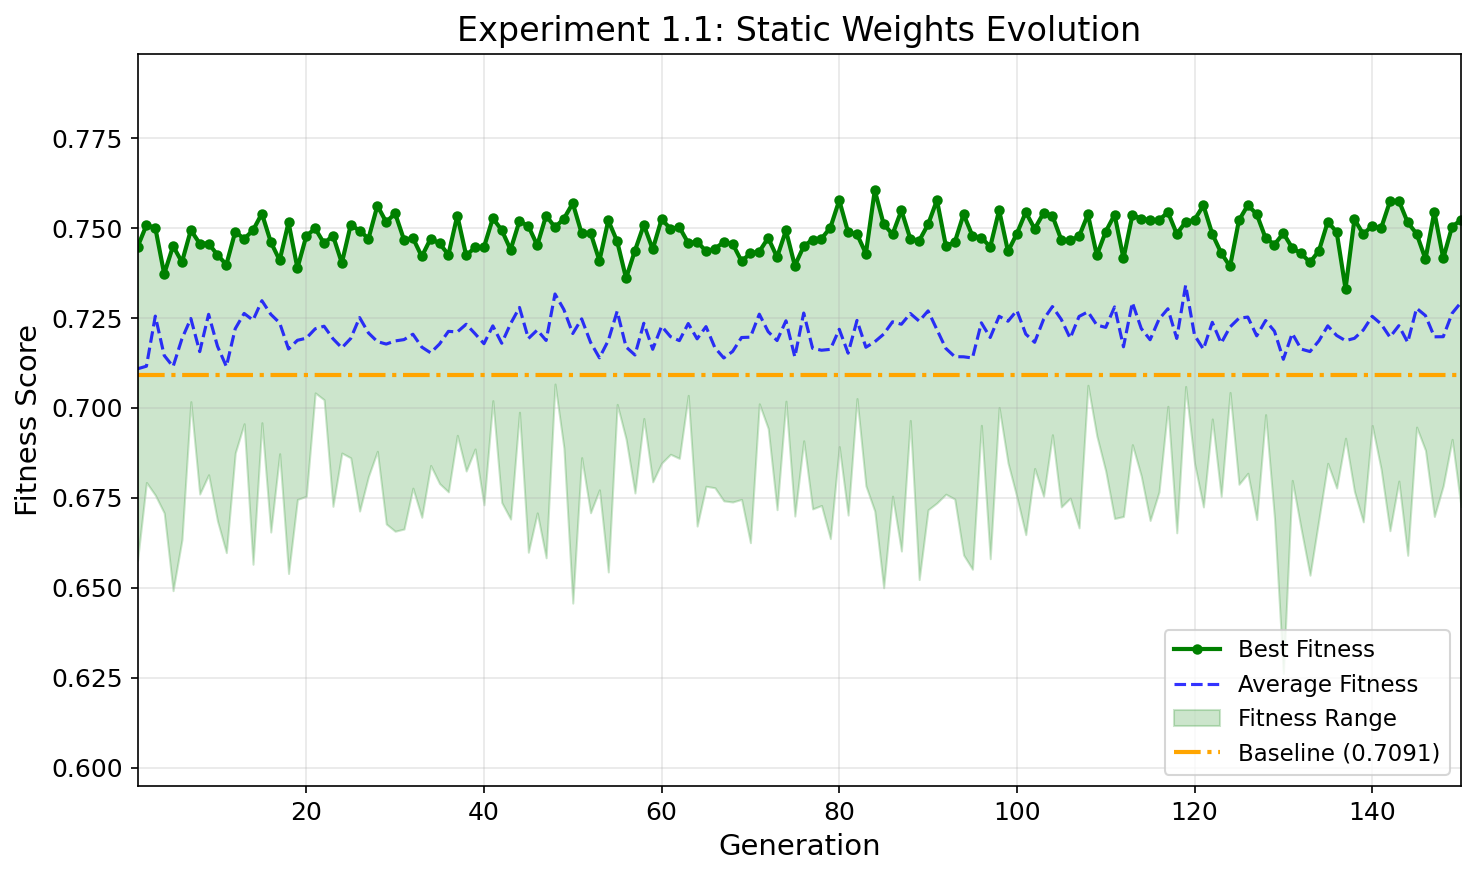

In [7]:
# Visualize static experiment convergence
fig_static = visualize_results(
    static_history, 
    baseline_score,
    title="Experiment 1.1: Static Weights Evolution"
)
fig_static.savefig(OUTPUT_DIR / "exp1_1_convergence.png")
plt.show()

## Cell 7: Run Experiment 1.2 (Adaptive Weights)

In [8]:
print("=" * 60)
print("EXPERIMENT 1.2: ADAPTIVE WEIGHTS")
print(f"CLIP Weight: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"Aesthetic Weight: {1 - INITIAL_CLIP_WEIGHT} -> {1 - FINAL_CLIP_WEIGHT}")
print("Strategy: Start semantic-focused, end aesthetic-focused")
print("=" * 60)

# Re-create adaptive evaluator to reset state
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)

# Run experiment with adaptive weights
adaptive_history, adaptive_population = run_experiment(
    evaluator=adaptive_evaluator,
    experiment_name="exp1_2_adaptive",
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=True
)

# Get best genome from adaptive experiment
best_adaptive_genome = max(adaptive_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.2 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_adaptive_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_adaptive_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_adaptive_genome.negative_modifiers}")
print(f"\nTotal images generated: {len(ALL_RESULTS)}")

EXPERIMENT 1.2: ADAPTIVE WEIGHTS
CLIP Weight: 0.8 -> 0.4
Aesthetic Weight: 0.19999999999999996 -> 0.6
Strategy: Start semantic-focused, end aesthetic-focused
Initializing CLIP model on cpu...
CLIP model loaded successfully
Initializing population of 20 genomes...

--- Generation 1/150 ---
Weights: CLIP=0.80, Aesthetic=0.20


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7052 | Avg: 0.6873 | Diversity: 0.15
Best prompt: a tiger in the jungle, leading lines...

--- Generation 2/150 ---
Weights: CLIP=0.80, Aesthetic=0.20


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7056 | Avg: 0.6882 | Diversity: 0.13
Best prompt: a tiger in the jungle, painterly lighting, implied lines, macro shot, dolly shot...

--- Generation 3/150 ---
Weights: CLIP=0.79, Aesthetic=0.21


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7073 | Avg: 0.6924 | Diversity: 0.09
Best prompt: a tiger in the jungle...

--- Generation 4/150 ---
Weights: CLIP=0.79, Aesthetic=0.21


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7012 | Avg: 0.6891 | Diversity: 0.10
Best prompt: a tiger in the jungle, photorealistic, constructivist, zooming in...

--- Generation 5/150 ---
Weights: CLIP=0.79, Aesthetic=0.21


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7045 | Avg: 0.6914 | Diversity: 0.12
Best prompt: a tiger in the jungle, cel-shaded, bloom effect, bright, fresco...

VOCABULARY EXPANSION (Generation 5)
Added 4 new modifiers
  style: encaustic painting
  quality: hyperrealistic, high fidelity, photorealistic details

AFTER EXPANSION:
  composition :  241 modifiers
  lighting    :  197 modifiers
  style       :  235 modifiers
  quality     :  135 modifiers
  negative    :  191 modifiers
  TOTAL       :  999 modifiers
  Synonym mappings: 18

  Updated vocabulary: 808 positive, 191 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_05

--- Generation 6/150 ---
Weights: CLIP=0.79, Aesthetic=0.21


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7094 | Avg: 0.6947 | Diversity: 0.12
Best prompt: a tiger in the jungle, cel-shaded, bloom effect, bright, fresco...

--- Generation 7/150 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7084 | Avg: 0.6948 | Diversity: 0.13
Best prompt: a tiger in the jungle, luminescent lighting, vibrant, responsive, minimalism, hi...

--- Generation 8/150 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7056 | Avg: 0.6947 | Diversity: 0.14
Best prompt: a tiger in the jungle, luminescent lighting, vibrant, dynamic pose, artistic arr...

--- Generation 9/150 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7077 | Avg: 0.6965 | Diversity: 0.14
Best prompt: a tiger in the jungle, painterly composition, comic book style, bright, cinemati...

--- Generation 10/150 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7055 | Avg: 0.6914 | Diversity: 0.15
Best prompt: a tiger in the jungle, dreamlike, minimalism, photorealistic rendering, miro sty...

VOCABULARY EXPANSION (Generation 10)
Added 3 new modifiers
  composition: isometric perspective
  style: neoclassical
  quality: cinematic

AFTER EXPANSION:
  composition :  242 modifiers
  lighting    :  197 modifiers
  style       :  236 modifiers
  quality     :  136 modifiers
  negative    :  191 modifiers
  TOTAL       : 1002 modifiers
  Synonym mappings: 18

  Updated vocabulary: 811 positive, 191 negative

VOCABULARY PRUNING (Generation 10)
No modifiers pruned

AFTER PRUNING:
  composition :  242 modifiers
  lighting    :  197 modifiers
  style       :  236 modifiers
  quality     :  136 modifiers
  negative    :  191 modifiers
  TOTAL       : 1002 modifiers
  Synonym mappings: 18

Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_10

--- Generation 11/150 ---
Weights: CLIP=0.77, Aesthetic=0.23


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7087 | Avg: 0.6903 | Diversity: 0.18
Best prompt: a tiger in the jungle, dreamlike, minimalism, photorealistic rendering, miro sty...

--- Generation 12/150 ---
Weights: CLIP=0.77, Aesthetic=0.23


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7109 | Avg: 0.6972 | Diversity: 0.17
Best prompt: a tiger in the jungle, national geographic, calligraphy, photorealistic renderin...

--- Generation 13/150 ---
Weights: CLIP=0.77, Aesthetic=0.23


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7080 | Avg: 0.6966 | Diversity: 0.15
Best prompt: a tiger in the jungle, action shot, handheld shot, golden ratio composition, cub...

--- Generation 14/150 ---
Weights: CLIP=0.77, Aesthetic=0.23


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7091 | Avg: 0.6959 | Diversity: 0.16
Best prompt: a tiger in the jungle, dreamlike, klee style, photorealistic rendering, scale...

--- Generation 15/150 ---
Weights: CLIP=0.76, Aesthetic=0.24


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7186 | Avg: 0.6977 | Diversity: 0.12
Best prompt: a tiger in the jungle, low angle, tracking shot, hdr...

VOCABULARY EXPANSION (Generation 15)
Added 9 new modifiers
  composition: portrait, candid shot
  lighting: silhouette
  style: gothic architecture, victorian era
  quality: ultra quality
  negative: mutated limbs, extra digits, cluttered

AFTER EXPANSION:
  composition :  244 modifiers
  lighting    :  198 modifiers
  style       :  238 modifiers
  quality     :  137 modifiers
  negative    :  194 modifiers
  TOTAL       : 1011 modifiers
  Synonym mappings: 18

  Updated vocabulary: 817 positive, 194 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_15

--- Generation 16/150 ---
Weights: CLIP=0.76, Aesthetic=0.24


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7117 | Avg: 0.6934 | Diversity: 0.14
Best prompt: a tiger in the jungle, low angle, tracking shot, hdr, medieval, balance, high fi...

--- Generation 17/150 ---
Weights: CLIP=0.76, Aesthetic=0.24


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7124 | Avg: 0.6993 | Diversity: 0.13
Best prompt: a tiger in the jungle, soft lighting...

--- Generation 18/150 ---
Weights: CLIP=0.75, Aesthetic=0.25


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7109 | Avg: 0.6935 | Diversity: 0.11
Best prompt: a tiger in the jungle...

--- Generation 19/150 ---
Weights: CLIP=0.75, Aesthetic=0.25


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7076 | Avg: 0.6948 | Diversity: 0.12
Best prompt: a tiger in the jungle, wide-angle lens, dieselpunk...

--- Generation 20/150 ---
Weights: CLIP=0.75, Aesthetic=0.25


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7112 | Avg: 0.6985 | Diversity: 0.16
Best prompt: a tiger in the jungle, scattered light, award winning, off-center composition, w...

VOCABULARY EXPANSION (Generation 20)
Added 4 new modifiers
  composition: fisheye lens effect
  lighting: lens flare
  style: high poly
  quality: photorealistic rendering

AFTER EXPANSION:
  composition :  245 modifiers
  lighting    :  199 modifiers
  style       :  239 modifiers
  quality     :  138 modifiers
  negative    :  194 modifiers
  TOTAL       : 1015 modifiers
  Synonym mappings: 18

  Updated vocabulary: 821 positive, 194 negative

VOCABULARY PRUNING (Generation 20)
No modifiers pruned

AFTER PRUNING:
  composition :  245 modifiers
  lighting    :  199 modifiers
  style       :  239 modifiers
  quality     :  138 modifiers
  negative    :  194 modifiers
  TOTAL       : 1015 modifiers
  Synonym mappings: 18

Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_20

--- Generation 21/150 ---
Weights: CLIP=0.75, Aesthet

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7147 | Avg: 0.6991 | Diversity: 0.15
Best prompt: a tiger in the jungle, adult swim style, breathtaking, sunlight, photon mapping,...

--- Generation 22/150 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7174 | Avg: 0.7052 | Diversity: 0.17
Best prompt: a tiger in the jungle, medium shot, highly textured, volumetric lighting, mixed ...

--- Generation 23/150 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7174 | Avg: 0.6976 | Diversity: 0.14
Best prompt: a tiger in the jungle, medium shot, highly textured, volumetric lighting, photor...

--- Generation 24/150 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7190 | Avg: 0.6982 | Diversity: 0.14
Best prompt: a tiger in the jungle, tilt-shift lens, landscape...

--- Generation 25/150 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7156 | Avg: 0.7000 | Diversity: 0.15
Best prompt: a tiger in the jungle, environmental lighting, highly textured, dutch angle, eth...

VOCABULARY EXPANSION (Generation 25)
Added 6 new modifiers
  composition: dutch angle shot, centered composition
  lighting: subtle lighting, spot lighting
  quality: ultra high definition, photorealistic quality

AFTER EXPANSION:
  composition :  247 modifiers
  lighting    :  201 modifiers
  style       :  239 modifiers
  quality     :  140 modifiers
  negative    :  194 modifiers
  TOTAL       : 1021 modifiers
  Synonym mappings: 18

  Updated vocabulary: 827 positive, 194 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_25

--- Generation 26/150 ---
Weights: CLIP=0.73, Aesthetic=0.27


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7158 | Avg: 0.7000 | Diversity: 0.16
Best prompt: a tiger in the jungle, handheld shot, character design, isometric illustration, ...

--- Generation 27/150 ---
Weights: CLIP=0.73, Aesthetic=0.27


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7150 | Avg: 0.6956 | Diversity: 0.13
Best prompt: a tiger in the jungle...

--- Generation 28/150 ---
Weights: CLIP=0.73, Aesthetic=0.27


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7170 | Avg: 0.7007 | Diversity: 0.13
Best prompt: a tiger in the jungle, dribbble, contemporary, fish eye lens, backlighting, vivi...

--- Generation 29/150 ---
Weights: CLIP=0.73, Aesthetic=0.27


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7193 | Avg: 0.6969 | Diversity: 0.12
Best prompt: a tiger in the jungle, pixel art, mass effect style, photorealistic details, dig...

--- Generation 30/150 ---
Weights: CLIP=0.72, Aesthetic=0.28


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7205 | Avg: 0.7018 | Diversity: 0.15
Best prompt: a tiger in the jungle...

VOCABULARY EXPANSION (Generation 30)
Added 4 new modifiers
  composition: cutout
  lighting: noir lighting
  style: surreal digital art, cartoonish style

AFTER EXPANSION:
  composition :  248 modifiers
  lighting    :  202 modifiers
  style       :  241 modifiers
  quality     :  140 modifiers
  negative    :  194 modifiers
  TOTAL       : 1025 modifiers
  Synonym mappings: 18

  Updated vocabulary: 831 positive, 194 negative

VOCABULARY PRUNING (Generation 30)
Pruned 2 unused modifiers

AFTER PRUNING:
  composition :  248 modifiers
  lighting    :  202 modifiers
  style       :  241 modifiers
  quality     :  138 modifiers
  negative    :  194 modifiers
  TOTAL       : 1023 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 829 positive, 194 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_30

--- Generation 31/150 ---
Weights: CLIP=0.72, Aesthetic=0.28


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7253 | Avg: 0.7055 | Diversity: 0.15
Best prompt: a tiger in the jungle, rococo, minimalist, close up, fine details, children's bo...

--- Generation 32/150 ---
Weights: CLIP=0.72, Aesthetic=0.28


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7199 | Avg: 0.7040 | Diversity: 0.16
Best prompt: a tiger in the jungle, tilting, photorealistic details, digital art, direct ligh...

--- Generation 33/150 ---
Weights: CLIP=0.71, Aesthetic=0.29


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7182 | Avg: 0.7026 | Diversity: 0.17
Best prompt: a tiger in the jungle, anamorphic lens flare, synthetism, pixar style, chiaroscu...

--- Generation 34/150 ---
Weights: CLIP=0.71, Aesthetic=0.29


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7220 | Avg: 0.7017 | Diversity: 0.16
Best prompt: a tiger in the jungle, warhol style, photorealistic details, landscape orientati...

--- Generation 35/150 ---
Weights: CLIP=0.71, Aesthetic=0.29


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7173 | Avg: 0.7035 | Diversity: 0.18
Best prompt: a tiger in the jungle, fill light, photorealistic details, digital art, direct l...

VOCABULARY EXPANSION (Generation 35)
Added 4 new modifiers
  composition: wide angle shot
  quality: hyperrealistic, vibrant colors, clean lines

AFTER EXPANSION:
  composition :  249 modifiers
  lighting    :  202 modifiers
  style       :  241 modifiers
  quality     :  141 modifiers
  negative    :  194 modifiers
  TOTAL       : 1027 modifiers
  Synonym mappings: 18

  Updated vocabulary: 833 positive, 194 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_35

--- Generation 36/150 ---
Weights: CLIP=0.71, Aesthetic=0.29


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7215 | Avg: 0.7070 | Diversity: 0.17
Best prompt: a tiger in the jungle, scrim, minimalist, conceptual art, bottom lighting, child...

--- Generation 37/150 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7271 | Avg: 0.7055 | Diversity: 0.17
Best prompt: a tiger in the jungle, scrim, panoramic view, group shot, 8k resolution, minimal...

--- Generation 38/150 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7220 | Avg: 0.7059 | Diversity: 0.19
Best prompt: a tiger in the jungle, low contrast lighting, symmetrical balance, isometric per...

--- Generation 39/150 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7228 | Avg: 0.7035 | Diversity: 0.18
Best prompt: a tiger in the jungle, abstraction, artstation trending, luminescent, award winn...

--- Generation 40/150 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7221 | Avg: 0.7011 | Diversity: 0.17
Best prompt: a tiger in the jungle, intricate details, highly detailed, diffused light, actio...

VOCABULARY EXPANSION (Generation 40)
Added 8 new modifiers
  lighting: color grading
  style: retro anime style, vaporwave aesthetic, synthwave style, steampunk aesthetic, dieselpunk aesthetic...
  negative: duplicate bodies

AFTER EXPANSION:
  composition :  249 modifiers
  lighting    :  203 modifiers
  style       :  247 modifiers
  quality     :  141 modifiers
  negative    :  195 modifiers
  TOTAL       : 1035 modifiers
  Synonym mappings: 18

  Updated vocabulary: 840 positive, 195 negative

VOCABULARY PRUNING (Generation 40)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  249 modifiers
  lighting    :  201 modifiers
  style       :  247 modifiers
  quality     :  140 modifiers
  negative    :  194 modifiers
  TOTAL       : 1031 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 837 positive, 194 negative
Chec

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7211 | Avg: 0.7064 | Diversity: 0.17
Best prompt: a tiger in the jungle, low contrast lighting, three-point perspective, de chiric...

--- Generation 42/150 ---
Weights: CLIP=0.69, Aesthetic=0.31


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7282 | Avg: 0.7046 | Diversity: 0.19
Best prompt: a tiger in the jungle, time-lapse, cowboy shot, sketch, pre-raphaelite, planar p...

--- Generation 43/150 ---
Weights: CLIP=0.69, Aesthetic=0.31


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7240 | Avg: 0.7082 | Diversity: 0.19
Best prompt: a tiger in the jungle, time-lapse, assemblage, environmental storytelling, pre-r...

--- Generation 44/150 ---
Weights: CLIP=0.69, Aesthetic=0.31


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7244 | Avg: 0.7116 | Diversity: 0.18
Best prompt: a tiger in the jungle, call of duty style, rembrandt lighting, tribal art, circu...

--- Generation 45/150 ---
Weights: CLIP=0.68, Aesthetic=0.32


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7258 | Avg: 0.7038 | Diversity: 0.17
Best prompt: a tiger in the jungle, graphic novel, artstation trending, hyperdetailed, rule o...

VOCABULARY EXPANSION (Generation 45)
Added 2 new modifiers
  lighting: silhouette
  style: analog horror

AFTER EXPANSION:
  composition :  249 modifiers
  lighting    :  202 modifiers
  style       :  248 modifiers
  quality     :  140 modifiers
  negative    :  194 modifiers
  TOTAL       : 1033 modifiers
  Synonym mappings: 18

  Updated vocabulary: 839 positive, 194 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_45

--- Generation 46/150 ---
Weights: CLIP=0.68, Aesthetic=0.32


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7237 | Avg: 0.7081 | Diversity: 0.19
Best prompt: a tiger in the jungle, comic book, gorgeous, hyperdetailed, rule of thirds, enha...

--- Generation 47/150 ---
Weights: CLIP=0.68, Aesthetic=0.32


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7222 | Avg: 0.7012 | Diversity: 0.14
Best prompt: a tiger in the jungle, rule of thirds, atmospheric lighting, constructivism, alg...

--- Generation 48/150 ---
Weights: CLIP=0.67, Aesthetic=0.33


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7319 | Avg: 0.7075 | Diversity: 0.14
Best prompt: a tiger in the jungle, dynamic frame, gorgeous, hyperdetailed, rule of thirds, e...

--- Generation 49/150 ---
Weights: CLIP=0.67, Aesthetic=0.33


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7339 | Avg: 0.7087 | Diversity: 0.16
Best prompt: a tiger in the jungle, assassin's creed style, centered composition, candid, gro...

--- Generation 50/150 ---
Weights: CLIP=0.67, Aesthetic=0.33


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7358 | Avg: 0.7079 | Diversity: 0.17
Best prompt: a tiger in the jungle, dramatic perspective, cycles render, low poly, rule of th...

VOCABULARY EXPANSION (Generation 50)
Added 2 new modifiers
  quality: hyper detailed
  negative: mutated fingers

AFTER EXPANSION:
  composition :  249 modifiers
  lighting    :  202 modifiers
  style       :  248 modifiers
  quality     :  141 modifiers
  negative    :  195 modifiers
  TOTAL       : 1035 modifiers
  Synonym mappings: 18

  Updated vocabulary: 840 positive, 195 negative

VOCABULARY PRUNING (Generation 50)
Pruned 2 unused modifiers

AFTER PRUNING:
  composition :  249 modifiers
  lighting    :  202 modifiers
  style       :  248 modifiers
  quality     :  139 modifiers
  negative    :  195 modifiers
  TOTAL       : 1033 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 838 positive, 195 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_50

--- Generation 51/150 ---
Weights: CLIP=0.6

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7322 | Avg: 0.7157 | Diversity: 0.13
Best prompt: a tiger in the jungle, photorealistic rendering, rule of thirds, dynamic angle, ...

--- Generation 52/150 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7305 | Avg: 0.7114 | Diversity: 0.12
Best prompt: a tiger in the jungle, call of duty style, rule of thirds, phosphorescent lighti...

--- Generation 53/150 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7316 | Avg: 0.7023 | Diversity: 0.16
Best prompt: a tiger in the jungle, unblurred, futurist...

--- Generation 54/150 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7318 | Avg: 0.7128 | Diversity: 0.15
Best prompt: a tiger in the jungle, subject isolation, artistic arrangement, halogen, respons...

--- Generation 55/150 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7288 | Avg: 0.7046 | Diversity: 0.18
Best prompt: a tiger in the jungle, pixar style, vivid, diegetic lighting, double exposure, n...

VOCABULARY EXPANSION (Generation 55)
Added 88 new modifiers
  composition: Worm's eye view, Over-the-shoulder shot, Long shot, Medium shot, Rule of thirds...
  lighting: Rim lighting, Backlighting, Hard lighting, Soft lighting, Dramatic lighting...
  style: Art Deco, Steampunk, Cyberpunk, Gothic art, Renaissance art...
  quality: High detail, Sharp focus, Photorealistic, Ultra-detailed, Intricate details...
  negative: Blurry, Out of focus, Grainy, Low resolution, Distorted...

AFTER EXPANSION:
  composition :  268 modifiers
  lighting    :  222 modifiers
  style       :  268 modifiers
  quality     :  148 modifiers
  negative    :  215 modifiers
  TOTAL       : 1121 modifiers
  Synonym mappings: 18

  Updated vocabulary: 906 positive, 215 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_55

--- Generation 56/150 ---

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7312 | Avg: 0.7079 | Diversity: 0.13
Best prompt: a tiger in the jungle, zooming out, defined, cel-shaded, baroque art, full frame...

--- Generation 57/150 ---
Weights: CLIP=0.65, Aesthetic=0.35


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7373 | Avg: 0.7101 | Diversity: 0.11
Best prompt: a tiger in the jungle, zooming out, defined, close-up, baroque art, full frame, ...

--- Generation 58/150 ---
Weights: CLIP=0.65, Aesthetic=0.35


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7375 | Avg: 0.7139 | Diversity: 0.11
Best prompt: a tiger in the jungle, saturated colors, optimal lighting, snowy lighting, voxel...

--- Generation 59/150 ---
Weights: CLIP=0.65, Aesthetic=0.35


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7366 | Avg: 0.7125 | Diversity: 0.14
Best prompt: a tiger in the jungle, zooming out, tracking shot, snowy lighting, specular ligh...

--- Generation 60/150 ---
Weights: CLIP=0.64, Aesthetic=0.36


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7371 | Avg: 0.7171 | Diversity: 0.15
Best prompt: a tiger in the jungle, High detail, optimal lighting, call of duty style, voxel ...

VOCABULARY EXPANSION (Generation 60)
Added 6 new modifiers
  composition: zoom burst, silhouette shot, diorama, close-up of hands
  style: atomic age, maximalist art

AFTER EXPANSION:
  composition :  272 modifiers
  lighting    :  222 modifiers
  style       :  270 modifiers
  quality     :  148 modifiers
  negative    :  215 modifiers
  TOTAL       : 1127 modifiers
  Synonym mappings: 18

  Updated vocabulary: 912 positive, 215 negative

VOCABULARY PRUNING (Generation 60)
Pruned 4 unused modifiers

AFTER PRUNING:
  composition :  272 modifiers
  lighting    :  221 modifiers
  style       :  269 modifiers
  quality     :  146 modifiers
  negative    :  215 modifiers
  TOTAL       : 1123 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 908 positive, 215 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptiv

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7337 | Avg: 0.7068 | Diversity: 0.19
Best prompt: a tiger in the jungle, drawing, panning, intricate detail, beauty dish, supremat...

--- Generation 62/150 ---
Weights: CLIP=0.64, Aesthetic=0.36


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7367 | Avg: 0.7091 | Diversity: 0.15
Best prompt: a tiger in the jungle, symmetrical balance, Photorealism, top lighting, cyberpun...

--- Generation 63/150 ---
Weights: CLIP=0.63, Aesthetic=0.37


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7381 | Avg: 0.7127 | Diversity: 0.16
Best prompt: a tiger in the jungle, character design...

--- Generation 64/150 ---
Weights: CLIP=0.63, Aesthetic=0.37


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7367 | Avg: 0.7200 | Diversity: 0.17
Best prompt: a tiger in the jungle, tilt-shift photography, dynamic frame, Sharp focus, film ...

--- Generation 65/150 ---
Weights: CLIP=0.63, Aesthetic=0.37


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7414 | Avg: 0.7101 | Diversity: 0.17
Best prompt: a tiger in the jungle, assemblage...

VOCABULARY EXPANSION (Generation 65)
Added 11 new modifiers
  composition: tilted shot, bokeh effect
  lighting: butterfly lighting, backlight, octabox lighting, strip lighting, gel lighting...
  style: isometric
  quality: cinematic, vibrant colors

AFTER EXPANSION:
  composition :  274 modifiers
  lighting    :  227 modifiers
  style       :  270 modifiers
  quality     :  148 modifiers
  negative    :  215 modifiers
  TOTAL       : 1134 modifiers
  Synonym mappings: 18

  Updated vocabulary: 919 positive, 215 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_65

--- Generation 66/150 ---
Weights: CLIP=0.63, Aesthetic=0.37


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7409 | Avg: 0.7199 | Diversity: 0.16
Best prompt: a tiger in the jungle, fortnite style...

--- Generation 67/150 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7388 | Avg: 0.7179 | Diversity: 0.15
Best prompt: a tiger in the jungle, golden hour lighting, balanced lighting, fish eye lens, m...

--- Generation 68/150 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7393 | Avg: 0.7101 | Diversity: 0.12
Best prompt: a tiger in the jungle, golden hour lighting, balanced lighting, fish eye lens, m...

--- Generation 69/150 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7454 | Avg: 0.7177 | Diversity: 0.13
Best prompt: a tiger in the jungle, shallow focus, cinematic composition, watercolor, accurat...

--- Generation 70/150 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7498 | Avg: 0.7155 | Diversity: 0.14
Best prompt: a tiger in the jungle, shallow focus, subdivision surface, fauvist, accurate, ro...

VOCABULARY EXPANSION (Generation 70)
Added 5 new modifiers
  lighting: uplighting
  quality: muted colors, low contrast, anamorphic lens, blender render

AFTER EXPANSION:
  composition :  274 modifiers
  lighting    :  228 modifiers
  style       :  270 modifiers
  quality     :  152 modifiers
  negative    :  215 modifiers
  TOTAL       : 1139 modifiers
  Synonym mappings: 18

  Updated vocabulary: 924 positive, 215 negative

VOCABULARY PRUNING (Generation 70)
Pruned 2 unused modifiers

AFTER PRUNING:
  composition :  274 modifiers
  lighting    :  227 modifiers
  style       :  269 modifiers
  quality     :  152 modifiers
  negative    :  215 modifiers
  TOTAL       : 1137 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 922 positive, 215 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_70

---

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7468 | Avg: 0.7221 | Diversity: 0.14
Best prompt: a tiger in the jungle, cartoonish, film grain, high quality, Manga style, full s...

--- Generation 72/150 ---
Weights: CLIP=0.61, Aesthetic=0.39


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7505 | Avg: 0.7209 | Diversity: 0.15
Best prompt: a tiger in the jungle, enthralling, genuine, fauvist, detailed, group shot, high...

--- Generation 73/150 ---
Weights: CLIP=0.61, Aesthetic=0.39


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7387 | Avg: 0.7134 | Diversity: 0.16
Best prompt: a tiger in the jungle, enthralling, genuine, fauvist, detailed, group shot, high...

--- Generation 74/150 ---
Weights: CLIP=0.61, Aesthetic=0.39


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7562 | Avg: 0.7179 | Diversity: 0.15
Best prompt: a tiger in the jungle, enthralling, genuine, fauvist, detailed, attractive, high...

--- Generation 75/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7483 | Avg: 0.7232 | Diversity: 0.15
Best prompt: a tiger in the jungle, enthralling, genuine, fauvist, detailed, attractive, high...

VOCABULARY EXPANSION (Generation 75)
Added 3 new modifiers
  quality: ultra sharp, cinematic quality
  negative: amateur photography

AFTER EXPANSION:
  composition :  274 modifiers
  lighting    :  227 modifiers
  style       :  269 modifiers
  quality     :  154 modifiers
  negative    :  216 modifiers
  TOTAL       : 1140 modifiers
  Synonym mappings: 18

  Updated vocabulary: 924 positive, 216 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_75

--- Generation 76/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7447 | Avg: 0.7231 | Diversity: 0.16
Best prompt: a tiger in the jungle, neutral light, spot lighting, Extreme close-up, detailed ...

--- Generation 77/150 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7419 | Avg: 0.7194 | Diversity: 0.16
Best prompt: a tiger in the jungle, close proximity, split lighting, medical lighting, detail...

--- Generation 78/150 ---
Weights: CLIP=0.59, Aesthetic=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7397 | Avg: 0.7162 | Diversity: 0.16
Best prompt: a tiger in the jungle, neutral light, cloudy lighting, zooming out, worm's eye v...

--- Generation 79/150 ---
Weights: CLIP=0.59, Aesthetic=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7510 | Avg: 0.7182 | Diversity: 0.15
Best prompt: a tiger in the jungle, fish eye lens...

--- Generation 80/150 ---
Weights: CLIP=0.59, Aesthetic=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7531 | Avg: 0.7248 | Diversity: 0.18
Best prompt: a tiger in the jungle, fish eye lens...

VOCABULARY EXPANSION (Generation 80)
Added 32 new modifiers
  composition: Framing, Symmetrical balance, Asymmetrical balance, Birds-eye view, Worm's-eye view...
  lighting: Hard light, Soft light, Rembrandt lighting, Golden hour lighting, Blue hour lighting
  style: Biopunk, Gothic, Renaissance, Baroque, Bauhaus...
  quality: Ultra detailed, High resolution, 8K, 4K, Hyperrealistic...
  negative: Deformed, Disfigured, Extra limbs, Duplicate objects, Cropped

AFTER EXPANSION:
  composition :  282 modifiers
  lighting    :  232 modifiers
  style       :  276 modifiers
  quality     :  161 modifiers
  negative    :  221 modifiers
  TOTAL       : 1172 modifiers
  Synonym mappings: 18

  Updated vocabulary: 951 positive, 221 negative

VOCABULARY PRUNING (Generation 80)
Pruned 9 unused modifiers

AFTER PRUNING:
  composition :  279 modifiers
  lighting    :  231 modifiers
  style       :  271 m

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7486 | Avg: 0.7189 | Diversity: 0.14
Best prompt: a tiger in the jungle, contemporary, nabis, painterly composition, watercolor, f...

--- Generation 82/150 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7490 | Avg: 0.7241 | Diversity: 0.15
Best prompt: a tiger in the jungle, contemporary, split diopter, painterly composition, 3D re...

--- Generation 83/150 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7499 | Avg: 0.7205 | Diversity: 0.14
Best prompt: a tiger in the jungle, split screen, nabis, vector illustration, artistic compos...

--- Generation 84/150 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7535 | Avg: 0.7253 | Diversity: 0.17
Best prompt: a tiger in the jungle, snowy lighting, deep depth of field, overwatch style, gra...

--- Generation 85/150 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7634 | Avg: 0.7171 | Diversity: 0.17
Best prompt: a tiger in the jungle, contemporary, split diopter, back light, high-key lightin...

VOCABULARY EXPANSION (Generation 85)
Added 4 new modifiers
  composition: time-lapse photography, ground-level shot, parallax scrolling
  style: geometric abstraction

AFTER EXPANSION:
  composition :  282 modifiers
  lighting    :  231 modifiers
  style       :  272 modifiers
  quality     :  161 modifiers
  negative    :  221 modifiers
  TOTAL       : 1167 modifiers
  Synonym mappings: 18

  Updated vocabulary: 946 positive, 221 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_85

--- Generation 86/150 ---
Weights: CLIP=0.57, Aesthetic=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7477 | Avg: 0.7217 | Diversity: 0.16
Best prompt: a tiger in the jungle, snowy lighting, surgical lighting, worm's eye view, motiv...

--- Generation 87/150 ---
Weights: CLIP=0.57, Aesthetic=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7530 | Avg: 0.7185 | Diversity: 0.16
Best prompt: a tiger in the jungle, snowy lighting, overwatch style, sharp focus, deconstruct...

--- Generation 88/150 ---
Weights: CLIP=0.57, Aesthetic=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7527 | Avg: 0.7213 | Diversity: 0.15
Best prompt: a tiger in the jungle, occlusion, stylized...

--- Generation 89/150 ---
Weights: CLIP=0.57, Aesthetic=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7606 | Avg: 0.7300 | Diversity: 0.14
Best prompt: a tiger in the jungle, point-of-view shot, brutalist architecture, subdivision s...

--- Generation 90/150 ---
Weights: CLIP=0.56, Aesthetic=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7618 | Avg: 0.7344 | Diversity: 0.11
Best prompt: a tiger in the jungle, knee shot, nasa, subdivision surface, spherical panorama,...

VOCABULARY EXPANSION (Generation 90)
Added 5 new modifiers
  composition: tilt-shift effect, matte painting, time-slice photography
  style: lofi art
  quality: hyperrealistic

AFTER EXPANSION:
  composition :  285 modifiers
  lighting    :  231 modifiers
  style       :  273 modifiers
  quality     :  162 modifiers
  negative    :  221 modifiers
  TOTAL       : 1172 modifiers
  Synonym mappings: 18

  Updated vocabulary: 951 positive, 221 negative

VOCABULARY PRUNING (Generation 90)
Pruned 6 unused modifiers

AFTER PRUNING:
  composition :  285 modifiers
  lighting    :  231 modifiers
  style       :  272 modifiers
  quality     :  157 modifiers
  negative    :  221 modifiers
  TOTAL       : 1166 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 945 positive, 221 negative
Checkpoint saved to ../data/results/experiment_1/exp1

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7564 | Avg: 0.7235 | Diversity: 0.13
Best prompt: a tiger in the jungle, dieselpunk, nasa, diffusion panel, spherical panorama, lo...

--- Generation 92/150 ---
Weights: CLIP=0.56, Aesthetic=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7467 | Avg: 0.7178 | Diversity: 0.13
Best prompt: a tiger in the jungle, advanced technology...

--- Generation 93/150 ---
Weights: CLIP=0.55, Aesthetic=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7592 | Avg: 0.7290 | Diversity: 0.13
Best prompt: a tiger in the jungle, point-of-view shot, brutalist architecture, subdivision s...

--- Generation 94/150 ---
Weights: CLIP=0.55, Aesthetic=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7522 | Avg: 0.7262 | Diversity: 0.12
Best prompt: a tiger in the jungle, photon mapping, isometric view, Infrared lighting, Minima...

--- Generation 95/150 ---
Weights: CLIP=0.55, Aesthetic=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7566 | Avg: 0.7253 | Diversity: 0.13
Best prompt: a tiger in the jungle, close-up on face, brutalist architecture, worm's eye view...

VOCABULARY EXPANSION (Generation 95)
Added 14 new modifiers
  composition: surreal composition, narrative composition, highly detailed background, foreground element
  lighting: low key lighting, high key lighting
  style: Art Deco, Steampunk, Rococo, Abstract Expressionism, Analog horror...
  quality: cinematic

AFTER EXPANSION:
  composition :  289 modifiers
  lighting    :  233 modifiers
  style       :  279 modifiers
  quality     :  158 modifiers
  negative    :  221 modifiers
  TOTAL       : 1180 modifiers
  Synonym mappings: 18

  Updated vocabulary: 959 positive, 221 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_95

--- Generation 96/150 ---
Weights: CLIP=0.55, Aesthetic=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7599 | Avg: 0.7307 | Diversity: 0.13
Best prompt: a tiger in the jungle, vector art...

--- Generation 97/150 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7558 | Avg: 0.7318 | Diversity: 0.13
Best prompt: a tiger in the jungle, vector art, establishing shot, manga, digital painting...

--- Generation 98/150 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7505 | Avg: 0.7318 | Diversity: 0.13
Best prompt: a tiger in the jungle, close-up on face, brutalist architecture, retro anime sty...

--- Generation 99/150 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7510 | Avg: 0.7230 | Diversity: 0.12
Best prompt: a tiger in the jungle, rhythm, constructivist, cinematic composition, render qua...

--- Generation 100/150 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7633 | Avg: 0.7298 | Diversity: 0.12
Best prompt: a tiger in the jungle, rhythm, constructivist, cinematic composition, render qua...

VOCABULARY EXPANSION (Generation 100)
Added 12 new modifiers
  lighting: dappled sunlight, neon glow, lens flare
  style: cyberprep, outrun
  quality: cryengine, ultra-realistic, vibrant colors, highly detailed textures, post-processing
  negative: missing limb, floating limbs

AFTER EXPANSION:
  composition :  289 modifiers
  lighting    :  236 modifiers
  style       :  281 modifiers
  quality     :  163 modifiers
  negative    :  223 modifiers
  TOTAL       : 1192 modifiers
  Synonym mappings: 18

  Updated vocabulary: 969 positive, 223 negative

VOCABULARY PRUNING (Generation 100)
Pruned 9 unused modifiers

AFTER PRUNING:
  composition :  287 modifiers
  lighting    :  234 modifiers
  style       :  279 modifiers
  quality     :  160 modifiers
  negative    :  223 modifiers
  TOTAL       : 1183 modifiers
  Synonym mappings: 18

  Updated voc

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7605 | Avg: 0.7317 | Diversity: 0.11
Best prompt: a tiger in the jungle, solarpunk...

--- Generation 102/150 ---
Weights: CLIP=0.53, Aesthetic=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7624 | Avg: 0.7324 | Diversity: 0.13
Best prompt: a tiger in the jungle, solarpunk...

--- Generation 103/150 ---
Weights: CLIP=0.53, Aesthetic=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7670 | Avg: 0.7247 | Diversity: 0.12
Best prompt: a tiger in the jungle, rhythm, constructivist, watercolor painting, render quali...

--- Generation 104/150 ---
Weights: CLIP=0.53, Aesthetic=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7705 | Avg: 0.7388 | Diversity: 0.14
Best prompt: a tiger in the jungle, constructivist, relative size, dieselpunk, geometric comp...

--- Generation 105/150 ---
Weights: CLIP=0.52, Aesthetic=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7619 | Avg: 0.7397 | Diversity: 0.16
Best prompt: a tiger in the jungle, constructivist, relative size, dieselpunk, geometric comp...

VOCABULARY EXPANSION (Generation 105)
Added 5 new modifiers
  lighting: glowing orbs, dramatic shadows, caustic lighting
  style: isometric
  negative: poor composition

AFTER EXPANSION:
  composition :  287 modifiers
  lighting    :  237 modifiers
  style       :  280 modifiers
  quality     :  160 modifiers
  negative    :  224 modifiers
  TOTAL       : 1188 modifiers
  Synonym mappings: 18

  Updated vocabulary: 964 positive, 224 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_105

--- Generation 106/150 ---
Weights: CLIP=0.52, Aesthetic=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7695 | Avg: 0.7273 | Diversity: 0.17
Best prompt: a tiger in the jungle, constructivist, relative size, dieselpunk, geometric comp...

--- Generation 107/150 ---
Weights: CLIP=0.52, Aesthetic=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7739 | Avg: 0.7442 | Diversity: 0.15
Best prompt: a tiger in the jungle, constructivist, relative size, dieselpunk, geometric comp...

--- Generation 108/150 ---
Weights: CLIP=0.51, Aesthetic=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7680 | Avg: 0.7249 | Diversity: 0.17
Best prompt: a tiger in the jungle, constructivist, relative size, dieselpunk, geometric comp...

--- Generation 109/150 ---
Weights: CLIP=0.51, Aesthetic=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7587 | Avg: 0.7289 | Diversity: 0.15
Best prompt: a tiger in the jungle, digital art, Sharp focus, concept art, planar perspective...

--- Generation 110/150 ---
Weights: CLIP=0.51, Aesthetic=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7591 | Avg: 0.7310 | Diversity: 0.15
Best prompt: a tiger in the jungle, blender render, Rule of thirds, rim light, frida kahlo st...

VOCABULARY EXPANSION (Generation 110)
Added 2 new modifiers
  lighting: Rembrandt lighting
  quality: visually stunning

AFTER EXPANSION:
  composition :  287 modifiers
  lighting    :  238 modifiers
  style       :  280 modifiers
  quality     :  161 modifiers
  negative    :  224 modifiers
  TOTAL       : 1190 modifiers
  Synonym mappings: 18

  Updated vocabulary: 966 positive, 224 negative

VOCABULARY PRUNING (Generation 110)
Pruned 3 unused modifiers

AFTER PRUNING:
  composition :  285 modifiers
  lighting    :  238 modifiers
  style       :  280 modifiers
  quality     :  160 modifiers
  negative    :  224 modifiers
  TOTAL       : 1187 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 963 positive, 224 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_110

--- Generation 111/150 ---
Weights

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7796 | Avg: 0.7302 | Diversity: 0.14
Best prompt: a tiger in the jungle, two-point perspective, photorealistic rendering, watercol...

--- Generation 112/150 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7625 | Avg: 0.7311 | Diversity: 0.16
Best prompt: a tiger in the jungle, tilted horizon, Rule of thirds, rim light, simplification...

--- Generation 113/150 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7698 | Avg: 0.7417 | Diversity: 0.16
Best prompt: a tiger in the jungle, direct light, diorama, low resolution, Sharp focus, outsi...

--- Generation 114/150 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7621 | Avg: 0.7298 | Diversity: 0.14
Best prompt: a tiger in the jungle, clean lines, smooth gradient, golden ratio composition, c...

--- Generation 115/150 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7776 | Avg: 0.7392 | Diversity: 0.13
Best prompt: a tiger in the jungle, gothic art, smooth gradient, golden ratio composition, co...

VOCABULARY EXPANSION (Generation 115)
Added 7 new modifiers
  composition: pointillism composition, pyramidal composition
  quality: hyperrealism, extremely detailed, polished, refined
  negative: mutilated

AFTER EXPANSION:
  composition :  287 modifiers
  lighting    :  238 modifiers
  style       :  280 modifiers
  quality     :  164 modifiers
  negative    :  225 modifiers
  TOTAL       : 1194 modifiers
  Synonym mappings: 18

  Updated vocabulary: 969 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_115

--- Generation 116/150 ---
Weights: CLIP=0.49, Aesthetic=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7679 | Avg: 0.7383 | Diversity: 0.12
Best prompt: a tiger in the jungle, unmotivated lighting, smooth gradient, pollock style, ret...

--- Generation 117/150 ---
Weights: CLIP=0.49, Aesthetic=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7578 | Avg: 0.7323 | Diversity: 0.15
Best prompt: a tiger in the jungle, wide angle shot, dramatic angle, triptych, digital illumi...

--- Generation 118/150 ---
Weights: CLIP=0.49, Aesthetic=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7718 | Avg: 0.7312 | Diversity: 0.15
Best prompt: a tiger in the jungle, direct light, fallout style, low resolution, Sharp focus,...

--- Generation 119/150 ---
Weights: CLIP=0.49, Aesthetic=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7732 | Avg: 0.7411 | Diversity: 0.16
Best prompt: a tiger in the jungle, wide angle shot, complementary colors, Soft lighting, pro...

--- Generation 120/150 ---
Weights: CLIP=0.48, Aesthetic=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7731 | Avg: 0.7511 | Diversity: 0.13
Best prompt: a tiger in the jungle, fallout style, surreal pop, subdivision surface...

VOCABULARY EXPANSION (Generation 120)
Added 4 new modifiers
  composition: blurred foreground
  lighting: specular lighting, natural sunlight
  quality: hyperrealistic

AFTER EXPANSION:
  composition :  288 modifiers
  lighting    :  240 modifiers
  style       :  280 modifiers
  quality     :  165 modifiers
  negative    :  225 modifiers
  TOTAL       : 1198 modifiers
  Synonym mappings: 18

  Updated vocabulary: 973 positive, 225 negative

VOCABULARY PRUNING (Generation 120)
Pruned 3 unused modifiers

AFTER PRUNING:
  composition :  288 modifiers
  lighting    :  239 modifiers
  style       :  280 modifiers
  quality     :  163 modifiers
  negative    :  225 modifiers
  TOTAL       : 1195 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 970 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_1

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7712 | Avg: 0.7309 | Diversity: 0.15
Best prompt: a tiger in the jungle, tilted horizon, fallout style, low resolution, Constructi...

--- Generation 122/150 ---
Weights: CLIP=0.48, Aesthetic=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7744 | Avg: 0.7359 | Diversity: 0.14
Best prompt: a tiger in the jungle, narrative composition, complementary colors, scientific a...

--- Generation 123/150 ---
Weights: CLIP=0.47, Aesthetic=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7671 | Avg: 0.7330 | Diversity: 0.16
Best prompt: a tiger in the jungle, abstract expressionism, close proximity, specular highlig...

--- Generation 124/150 ---
Weights: CLIP=0.47, Aesthetic=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7712 | Avg: 0.7368 | Diversity: 0.14
Best prompt: a tiger in the jungle, tilted horizon, fallout style, comic book, soft shadows, ...

--- Generation 125/150 ---
Weights: CLIP=0.47, Aesthetic=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7784 | Avg: 0.7495 | Diversity: 0.13
Best prompt: a tiger in the jungle, captivating, dramatic perspective, amazing, watercolor pa...

VOCABULARY EXPANSION (Generation 125)
Added 4 new modifiers
  composition: high angle view, diptych, close-up of face
  lighting: silhouette

AFTER EXPANSION:
  composition :  291 modifiers
  lighting    :  240 modifiers
  style       :  280 modifiers
  quality     :  163 modifiers
  negative    :  225 modifiers
  TOTAL       : 1199 modifiers
  Synonym mappings: 18

  Updated vocabulary: 974 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_125

--- Generation 126/150 ---
Weights: CLIP=0.47, Aesthetic=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7770 | Avg: 0.7489 | Diversity: 0.15
Best prompt: a tiger in the jungle, high definition, low angle shot, oblique angle...

--- Generation 127/150 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7788 | Avg: 0.7370 | Diversity: 0.16
Best prompt: a tiger in the jungle, side profile, dramatic perspective, tracking shot, solar ...

--- Generation 128/150 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7810 | Avg: 0.7444 | Diversity: 0.15
Best prompt: a tiger in the jungle, softbox, dramatic perspective, lovely, muted lighting, di...

--- Generation 129/150 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7749 | Avg: 0.7427 | Diversity: 0.15
Best prompt: a tiger in the jungle, muted colors, liminal space...

--- Generation 130/150 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7840 | Avg: 0.7458 | Diversity: 0.16
Best prompt: a tiger in the jungle, pedestal shot, ultra sharp, soft light, animation, staged...

VOCABULARY EXPANSION (Generation 130)
Added 2 new modifiers
  composition: cropped
  lighting: directional light

AFTER EXPANSION:
  composition :  292 modifiers
  lighting    :  241 modifiers
  style       :  280 modifiers
  quality     :  163 modifiers
  negative    :  225 modifiers
  TOTAL       : 1201 modifiers
  Synonym mappings: 18

  Updated vocabulary: 976 positive, 225 negative

VOCABULARY PRUNING (Generation 130)
Pruned 1 unused modifiers

AFTER PRUNING:
  composition :  292 modifiers
  lighting    :  241 modifiers
  style       :  280 modifiers
  quality     :  162 modifiers
  negative    :  225 modifiers
  TOTAL       : 1200 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 975 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_130

--- Generation 131/150 ---
Weights: CLIP=

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7806 | Avg: 0.7447 | Diversity: 0.14
Best prompt: a tiger in the jungle, hyperrealism, synthetism, low angle, vintage, nabis, cris...

--- Generation 132/150 ---
Weights: CLIP=0.45, Aesthetic=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7779 | Avg: 0.7310 | Diversity: 0.16
Best prompt: a tiger in the jungle, aerial shot, breathtaking, distinct, extreme wide angle, ...

--- Generation 133/150 ---
Weights: CLIP=0.45, Aesthetic=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7794 | Avg: 0.7433 | Diversity: 0.16
Best prompt: a tiger in the jungle, fish-eye lens, ultra sharp, isometric projection, bright,...

--- Generation 134/150 ---
Weights: CLIP=0.45, Aesthetic=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7914 | Avg: 0.7533 | Diversity: 0.16
Best prompt: a tiger in the jungle, museum of modern art, 3D rendering, panoramic, Ukiyo-e...

--- Generation 135/150 ---
Weights: CLIP=0.44, Aesthetic=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7820 | Avg: 0.7519 | Diversity: 0.16
Best prompt: a tiger in the jungle, crisp details, top lighting, watercolor, Rule of thirds, ...

VOCABULARY EXPANSION (Generation 135)
Added 3 new modifiers
  composition: chiaroscuro, rule of space, vignetting

AFTER EXPANSION:
  composition :  295 modifiers
  lighting    :  241 modifiers
  style       :  280 modifiers
  quality     :  162 modifiers
  negative    :  225 modifiers
  TOTAL       : 1203 modifiers
  Synonym mappings: 18

  Updated vocabulary: 978 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_135

--- Generation 136/150 ---
Weights: CLIP=0.44, Aesthetic=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7911 | Avg: 0.7480 | Diversity: 0.16
Best prompt: a tiger in the jungle, geometric abstraction, critically acclaimed, ultra-realis...

--- Generation 137/150 ---
Weights: CLIP=0.44, Aesthetic=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7789 | Avg: 0.7476 | Diversity: 0.17
Best prompt: a tiger in the jungle, bust shot, practical source, isometric projection, bird's...

--- Generation 138/150 ---
Weights: CLIP=0.43, Aesthetic=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7861 | Avg: 0.7526 | Diversity: 0.14
Best prompt: a tiger in the jungle, art brut, encaustic painting, rainy lighting, blurred bac...

--- Generation 139/150 ---
Weights: CLIP=0.43, Aesthetic=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7810 | Avg: 0.7413 | Diversity: 0.12
Best prompt: a tiger in the jungle, god rays, neutral light, dynamic frame, grainy, cgsociety...

--- Generation 140/150 ---
Weights: CLIP=0.43, Aesthetic=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7795 | Avg: 0.7481 | Diversity: 0.13
Best prompt: a tiger in the jungle, miniature painting, call of duty style...

VOCABULARY EXPANSION (Generation 140)
Added 8 new modifiers
  composition: panoramic vista, bokeh background
  lighting: color grading, high contrast, low contrast
  quality: ray tracing, screen space reflections, depth of field

AFTER EXPANSION:
  composition :  297 modifiers
  lighting    :  244 modifiers
  style       :  280 modifiers
  quality     :  165 modifiers
  negative    :  225 modifiers
  TOTAL       : 1211 modifiers
  Synonym mappings: 18

  Updated vocabulary: 986 positive, 225 negative

VOCABULARY PRUNING (Generation 140)
Pruned 2 unused modifiers

AFTER PRUNING:
  composition :  297 modifiers
  lighting    :  244 modifiers
  style       :  280 modifiers
  quality     :  163 modifiers
  negative    :  225 modifiers
  TOTAL       : 1209 modifiers
  Synonym mappings: 18

  Updated vocabulary after pruning: 984 positive, 225 negative
Checkpoint saved t

Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7859 | Avg: 0.7368 | Diversity: 0.13
Best prompt: a tiger in the jungle, Leading lines, calligraphy, assassin's creed style, Rule ...

--- Generation 142/150 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7734 | Avg: 0.7348 | Diversity: 0.13
Best prompt: a tiger in the jungle, miniature painting, call of duty style...

--- Generation 143/150 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7899 | Avg: 0.7411 | Diversity: 0.11
Best prompt: a tiger in the jungle, deconstructivism...

--- Generation 144/150 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7855 | Avg: 0.7557 | Diversity: 0.09
Best prompt: a tiger in the jungle, vignette, blender render...

--- Generation 145/150 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7836 | Avg: 0.7527 | Diversity: 0.10
Best prompt: a tiger in the jungle, spherical panorama, Steadicam shot, digital art, artistic...

VOCABULARY EXPANSION (Generation 145)
Added 6 new modifiers
  composition: extreme wide shot
  lighting: key lighting
  style: synthwave art, retrowave art, 3D render, low poly art

AFTER EXPANSION:
  composition :  298 modifiers
  lighting    :  245 modifiers
  style       :  284 modifiers
  quality     :  163 modifiers
  negative    :  225 modifiers
  TOTAL       : 1215 modifiers
  Synonym mappings: 18

  Updated vocabulary: 990 positive, 225 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_145

--- Generation 146/150 ---
Weights: CLIP=0.41, Aesthetic=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7782 | Avg: 0.7503 | Diversity: 0.10
Best prompt: a tiger in the jungle, spherical panorama, Steadicam shot, digital art, artistic...

--- Generation 147/150 ---
Weights: CLIP=0.41, Aesthetic=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7876 | Avg: 0.7570 | Diversity: 0.09
Best prompt: a tiger in the jungle, oblique projection, crisp image, gorgeous, cloudy lightin...

--- Generation 148/150 ---
Weights: CLIP=0.41, Aesthetic=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7877 | Avg: 0.7473 | Diversity: 0.11
Best prompt: a tiger in the jungle, Steadicam shot, one-point perspective, snoot, prime lens...

--- Generation 149/150 ---
Weights: CLIP=0.41, Aesthetic=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.7904 | Avg: 0.7446 | Diversity: 0.13
Best prompt: a tiger in the jungle, Bokeh, analogous colors, conceptual art, prime lens...

--- Generation 150/150 ---
Weights: CLIP=0.40, Aesthetic=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

2025-12-30 21:35:27,485 - experiment_1 - INFO - exp1_2_adaptive complete. Best fitness: 0.7928


Best: 0.7928 | Avg: 0.7551 | Diversity: 0.13
Best prompt: a tiger in the jungle, high resolution, ambient occlusion, Baroque, minecraft st...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_150

EXPERIMENT 1.2 RESULTS
Final Best Fitness: 0.7928
Improvement over baseline: 11.80%

Best Prompt:
  a tiger in the jungle, high resolution, ambient occlusion, Baroque, minecraft style, natural sunlight, Hyperrealism, pixel art, Constructivism

Positive Modifiers: ['high resolution', 'ambient occlusion', 'Baroque', 'minecraft style', 'natural sunlight', 'Hyperrealism', 'pixel art', 'Constructivism']
Negative Modifiers: ['unimaginative', 'Disproportionate', 'Extra limbs']

Total images generated: 6000


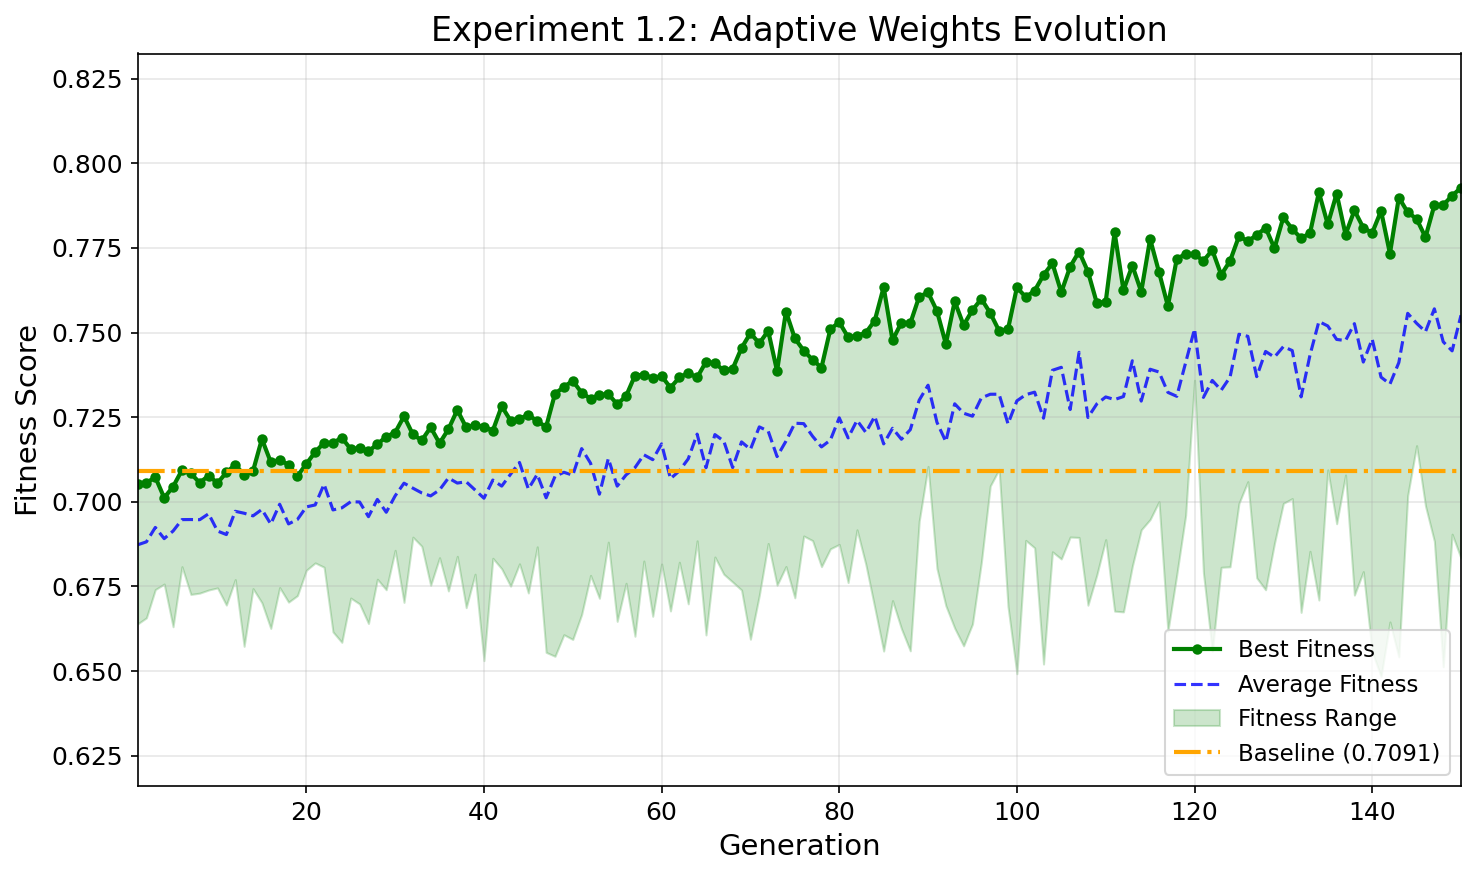

In [9]:
# Visualize adaptive experiment convergence
fig_adaptive = visualize_results(
    adaptive_history, 
    baseline_score,
    title="Experiment 1.2: Adaptive Weights Evolution"
)
fig_adaptive.savefig(OUTPUT_DIR / "exp1_2_convergence.png")
plt.show()

## Cell 8: Comparison & Statistical Analysis

COMPARISON: STATIC vs ADAPTIVE WEIGHTS


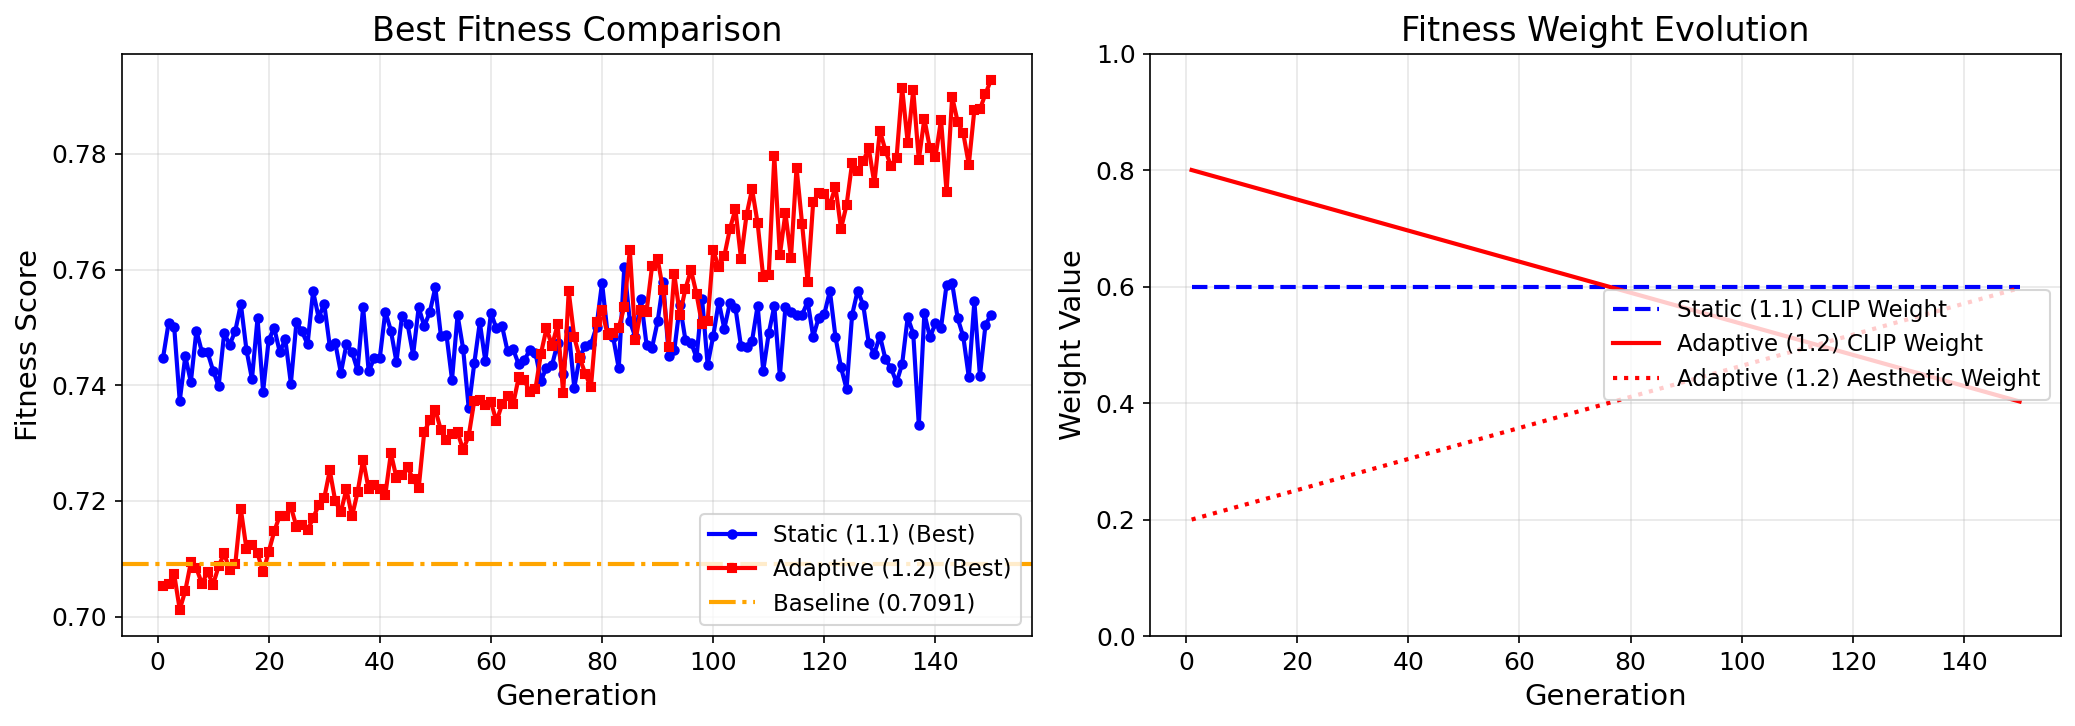


------------------------------------------------------------
STATISTICAL ANALYSIS
------------------------------------------------------------

Independent t-test:
  t-statistic: -3.8322
  p-value: 0.0005
  Significant (p < 0.05): Yes

Mann-Whitney U test:
  U-statistic: 62.0000
  p-value: 0.0002
  Significant (p < 0.05): Yes

------------------------------------------------------------
DESCRIPTIVE STATISTICS
------------------------------------------------------------

Baseline:
  Fitness: 0.7091

Static Weights (Exp 1.1):
  Mean:   0.7293
  Std:    0.0157
  Min:    0.6726
  Max:    0.7522
  Median: 0.7316

Adaptive Weights (Exp 1.2):
  Mean:   0.7551
  Std:    0.0247
  Min:    0.6834
  Max:    0.7928
  Median: 0.7614

Effect Size (Cohen's d): 1.2433
  Interpretation: large effect


In [10]:
print("=" * 60)
print("COMPARISON: STATIC vs ADAPTIVE WEIGHTS")
print("=" * 60)

# Side-by-side convergence comparison
fig_comparison = compare_experiments(
    static_history,
    adaptive_history,
    baseline_score,
    exp1_name="Static (1.1)",
    exp2_name="Adaptive (1.2)"
)
fig_comparison.savefig(OUTPUT_DIR / "comparison_plot.png")
plt.show()

# Extract final fitness values for statistical comparison
static_final = [g.fitness for g in static_population]
adaptive_final = [g.fitness for g in adaptive_population]

# Statistical tests
print("\n" + "-" * 60)
print("STATISTICAL ANALYSIS")
print("-" * 60)

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(static_final, adaptive_final)
print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(static_final, adaptive_final, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if u_pvalue < 0.05 else 'No'}")

# Descriptive statistics
print("\n" + "-" * 60)
print("DESCRIPTIVE STATISTICS")
print("-" * 60)

print(f"\nBaseline:")
print(f"  Fitness: {baseline_score:.4f}")

print(f"\nStatic Weights (Exp 1.1):")
print(f"  Mean:   {np.mean(static_final):.4f}")
print(f"  Std:    {np.std(static_final):.4f}")
print(f"  Min:    {np.min(static_final):.4f}")
print(f"  Max:    {np.max(static_final):.4f}")
print(f"  Median: {np.median(static_final):.4f}")

print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  Mean:   {np.mean(adaptive_final):.4f}")
print(f"  Std:    {np.std(adaptive_final):.4f}")
print(f"  Min:    {np.min(adaptive_final):.4f}")
print(f"  Max:    {np.max(adaptive_final):.4f}")
print(f"  Median: {np.median(adaptive_final):.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(static_final) - 1) * np.var(static_final) + 
                      (len(adaptive_final) - 1) * np.var(adaptive_final)) / 
                     (len(static_final) + len(adaptive_final) - 2))
cohens_d = (np.mean(adaptive_final) - np.mean(static_final)) / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation} effect")

/var/folders/p7/7kcv3ngd7q18v8lpks6vq25r0000gn/T/ipykernel_57834/66451307.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],


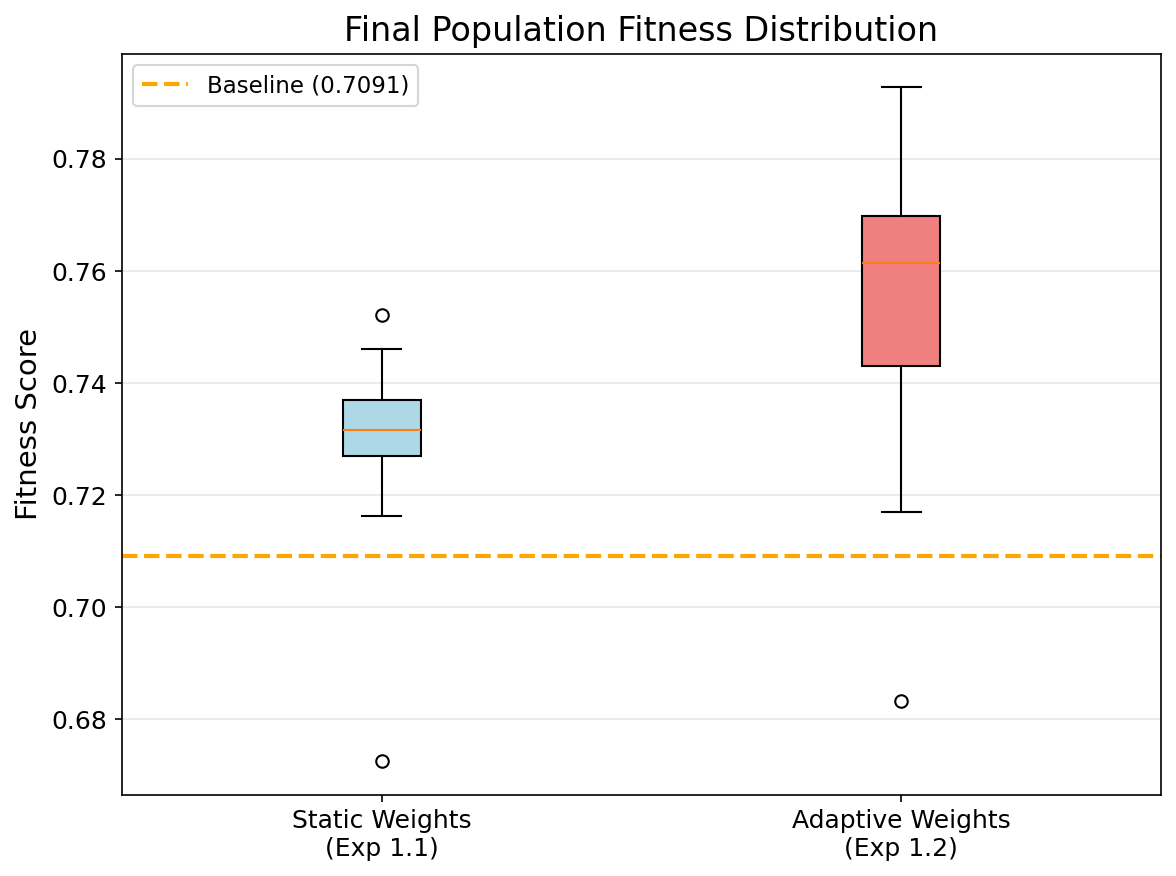

In [11]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = [static_final, adaptive_final]
bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],
                patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')

# Add baseline line
ax.axhline(y=baseline_score, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_score:.4f})')

ax.set_ylabel('Fitness Score')
ax.set_title('Final Population Fitness Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "boxplot_comparison.png")
plt.show()

## Cell 9: Visual Comparison

In [12]:
print("Generating final comparison images...")
print("This may take a moment...\n")

# Generate final images with consistent seed for fair comparison
COMPARISON_SEED = 12345

# Baseline image (already generated, but regenerate with comparison seed)
print("Generating baseline image...")
baseline_final_image, baseline_final_score = generate_final_image(
    factory.create_empty(BASE_PROMPT), 
    seed=COMPARISON_SEED
)

# Best static image
print("Generating best static weights image...")
static_final_image, static_final_score = generate_final_image(
    best_static_genome, 
    seed=COMPARISON_SEED
)

# Best adaptive image  
print("Generating best adaptive weights image...")
adaptive_final_image, adaptive_final_score = generate_final_image(
    best_adaptive_genome, 
    seed=COMPARISON_SEED
)

print("Image generation complete.")

Generating final comparison images...
This may take a moment...

Generating baseline image...
Generating best static weights image...
Generating best adaptive weights image...
Image generation complete.


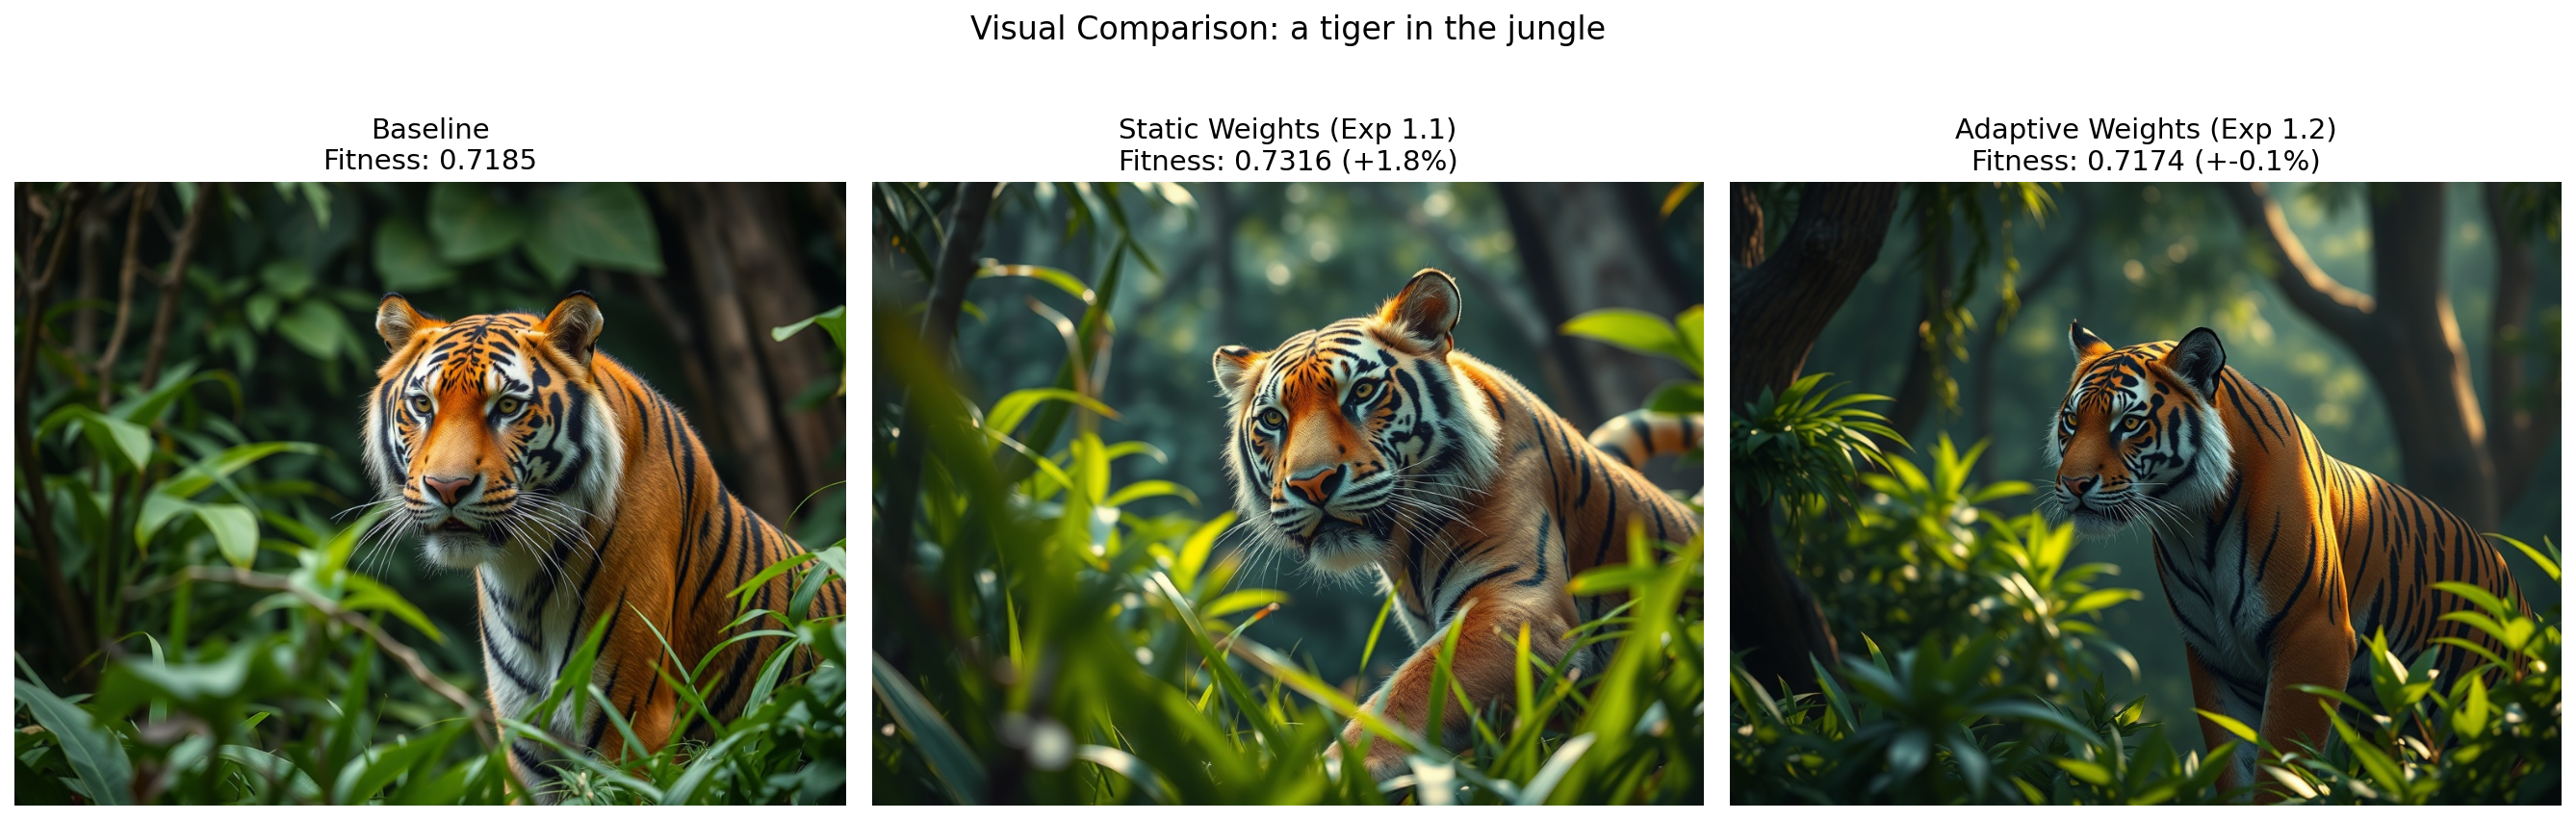


Images saved to output directory.


In [13]:
# Create side-by-side visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Baseline
axes[0].imshow(baseline_final_image)
axes[0].set_title(f"Baseline\nFitness: {baseline_final_score:.4f}", fontsize=14)
axes[0].axis('off')

# Static best
axes[1].imshow(static_final_image)
improvement_static = (static_final_score - baseline_final_score) / baseline_final_score * 100
axes[1].set_title(f"Static Weights (Exp 1.1)\nFitness: {static_final_score:.4f} (+{improvement_static:.1f}%)", fontsize=14)
axes[1].axis('off')

# Adaptive best
axes[2].imshow(adaptive_final_image)
improvement_adaptive = (adaptive_final_score - baseline_final_score) / baseline_final_score * 100
axes[2].set_title(f"Adaptive Weights (Exp 1.2)\nFitness: {adaptive_final_score:.4f} (+{improvement_adaptive:.1f}%)", fontsize=14)
axes[2].axis('off')

plt.suptitle(f"Visual Comparison: {BASE_PROMPT}", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_comparison.png", bbox_inches='tight')
plt.show()

# Save individual images
baseline_final_image.save(OUTPUT_DIR / "final_baseline.jpg")
static_final_image.save(OUTPUT_DIR / "final_static_best.jpg")
adaptive_final_image.save(OUTPUT_DIR / "final_adaptive_best.jpg")

print("\nImages saved to output directory.")

In [14]:
# Print evolved prompts for comparison
print("=" * 60)
print("EVOLVED PROMPTS COMPARISON")
print("=" * 60)

print(f"\nBASELINE PROMPT:")
print(f"  {BASE_PROMPT}")

print(f"\nSTATIC WEIGHTS BEST PROMPT:")
print(f"  {best_static_genome.to_prompt()}")
print(f"  Positive modifiers: {best_static_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_static_genome.negative_modifiers}")

print(f"\nADAPTIVE WEIGHTS BEST PROMPT:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"  Positive modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_adaptive_genome.negative_modifiers}")

EVOLVED PROMPTS COMPARISON

BASELINE PROMPT:
  a tiger in the jungle

STATIC WEIGHTS BEST PROMPT:
  a tiger in the jungle, halo style, hopper style, sharp details, lively, overexposed, renaissance, watercolor painting, foreground interest, worms-eye view, accurate, oblique angle, orthogonal projection
  Positive modifiers: ['halo style', 'hopper style', 'sharp details', 'lively', 'overexposed', 'renaissance', 'watercolor painting', 'foreground interest', 'worms-eye view', 'accurate', 'oblique angle', 'orthogonal projection']
  Negative modifiers: ['jpeg artifacts', 'dead', 'pixelated', 'crepuscular ray errors', 'grainy', 'god ray errors']

ADAPTIVE WEIGHTS BEST PROMPT:
  a tiger in the jungle, high resolution, ambient occlusion, Baroque, minecraft style, natural sunlight, Hyperrealism, pixel art, Constructivism
  Positive modifiers: ['high resolution', 'ambient occlusion', 'Baroque', 'minecraft style', 'natural sunlight', 'Hyperrealism', 'pixel art', 'Constructivism']
  Negative modifi

## Cell 10: Export Results for IEEE Paper

In [ ]:
# Compile all results for IEEE paper
print("Compiling results for IEEE paper export...")

# Convert numpy types to Python native types for JSON serialization
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj

# Prepare results dictionary
results = {
    "metadata": {
        "experiment": "1_prompt_enhancement",
        "timestamp": datetime.now().isoformat(),
        "random_seed": RANDOM_SEED,
        "model": MODEL_NAME
    },
    "configuration": {
        "population_size": POPULATION_SIZE,
        "max_generations": MAX_GENERATIONS,
        "elite_size": ELITE_SIZE,
        "mutation_rate": MUTATION_RATE,
        "max_positive_modifiers": MAX_POSITIVE_MODIFIERS,
        "max_negative_modifiers": MAX_NEGATIVE_MODIFIERS
    },
    "baseline": {
        "prompt": BASE_PROMPT,
        "fitness": float(baseline_score)
    },
    "static_weights": {
        "clip_weight": STATIC_CLIP_WEIGHT,
        "aesthetic_weight": STATIC_AESTHETIC_WEIGHT,
        "final_best_fitness": float(max(static_final)),
        "final_avg_fitness": float(np.mean(static_final)),
        "final_std_fitness": float(np.std(static_final)),
        "improvement_percent": float((max(static_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_static_genome.to_prompt(),
        "best_positive_modifiers": best_static_genome.positive_modifiers,
        "best_negative_modifiers": best_static_genome.negative_modifiers,
        "convergence_history": to_native(static_history)
    },
    "adaptive_weights": {
        "initial_clip_weight": INITIAL_CLIP_WEIGHT,
        "final_clip_weight": FINAL_CLIP_WEIGHT,
        "final_best_fitness": float(max(adaptive_final)),
        "final_avg_fitness": float(np.mean(adaptive_final)),
        "final_std_fitness": float(np.std(adaptive_final)),
        "improvement_percent": float((max(adaptive_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_adaptive_genome.to_prompt(),
        "best_positive_modifiers": best_adaptive_genome.positive_modifiers,
        "best_negative_modifiers": best_adaptive_genome.negative_modifiers,
        "convergence_history": to_native(adaptive_history)
    },
    "statistical_tests": {
        "t_test": {
            "t_statistic": float(t_stat),
            "p_value": float(p_value),
            "significant": bool(p_value < 0.05)
        },
        "mann_whitney_u": {
            "u_statistic": float(u_stat),
            "p_value": float(u_pvalue),
            "significant": bool(u_pvalue < 0.05)
        },
        "effect_size": {
            "cohens_d": float(cohens_d),
            "interpretation": effect_interpretation
        }
    },
    "comparison_summary": {
        "winner": "adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "static",
        "static_mean": float(np.mean(static_final)),
        "adaptive_mean": float(np.mean(adaptive_final)),
        "difference": float(np.mean(adaptive_final) - np.mean(static_final)),
        "relative_improvement": float((np.mean(adaptive_final) - np.mean(static_final)) / np.mean(static_final) * 100) if np.mean(static_final) > 0 else 0
    }
}

# Save to JSON
results_path = OUTPUT_DIR / "results_experiment_1.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Print summary for paper
print("\n" + "=" * 60)
print("SUMMARY FOR IEEE PAPER")
print("=" * 60)

print(f"\n1. BASELINE PERFORMANCE")
print(f"   - Fitness: {baseline_score:.4f}")

print(f"\n2. EXPERIMENT 1.1 (STATIC WEIGHTS)")
print(f"   - Best Fitness: {max(static_final):.4f}")
print(f"   - Mean Fitness: {np.mean(static_final):.4f} (+/- {np.std(static_final):.4f})")
print(f"   - Improvement: +{(max(static_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n3. EXPERIMENT 1.2 (ADAPTIVE WEIGHTS)")
print(f"   - Best Fitness: {max(adaptive_final):.4f}")
print(f"   - Mean Fitness: {np.mean(adaptive_final):.4f} (+/- {np.std(adaptive_final):.4f})")
print(f"   - Improvement: +{(max(adaptive_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n4. STATISTICAL SIGNIFICANCE")
print(f"   - t-test p-value: {p_value:.4f} ({'significant' if p_value < 0.05 else 'not significant'})")
print(f"   - Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")

winner = "Adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "Static"
print(f"\n5. CONCLUSION")
print(f"   - Better approach: {winner} Weights")
print(f"   - Difference in mean fitness: {abs(np.mean(adaptive_final) - np.mean(static_final)):.4f}")

In [ ]:
# Generate LaTeX table for paper
print("\n" + "=" * 60)
print("LaTeX TABLE FOR IEEE PAPER")
print("=" * 60)

latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Experiment 1: Prompt Enhancement Results}
\label{tab:exp1_results}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{Baseline} & \textbf{Static} & \textbf{Adaptive} \\
\hline
Best Fitness & %.4f & %.4f & %.4f \\
Mean Fitness & - & %.4f & %.4f \\
Std Dev & - & %.4f & %.4f \\
Improvement (\%%) & - & +%.2f\%% & +%.2f\%% \\
\hline
\multicolumn{4}{l}{\textit{Statistical Test: t=%.4f, p=%.4f}} \\
\multicolumn{4}{l}{\textit{Effect Size: Cohen's d=%.4f (%s)}} \\
\hline
\end{tabular}
\end{table}
""" % (
    baseline_score, max(static_final), max(adaptive_final),
    np.mean(static_final), np.mean(adaptive_final),
    np.std(static_final), np.std(adaptive_final),
    (max(static_final) - baseline_score) / baseline_score * 100,
    (max(adaptive_final) - baseline_score) / baseline_score * 100,
    t_stat, p_value, cohens_d, effect_interpretation
)

print(latex_table)

# Save LaTeX table
with open(OUTPUT_DIR / "table_experiment_1.tex", 'w') as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to: {OUTPUT_DIR / 'table_experiment_1.tex'}")

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("EXPERIMENT 1 COMPLETE")
print("=" * 60)

print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for f in sorted(OUTPUT_DIR.glob("*")):
    if f.is_file():
        print(f"  - {f.name}")

print("\nExperiment subdirectories:")
for d in sorted(OUTPUT_DIR.glob("exp*")):
    if d.is_dir():
        print(f"  - {d.name}/")

logger.info("Experiment 1 completed successfully.")
print("\nDone!")

## Cell 11: Return All Results Array

In [ ]:
# =============================================================================
# ALL RESULTS ARRAY
# =============================================================================
# This cell returns the complete results array with all generated images,
# prompts, and fitness scores.

print("=" * 60)
print("ALL RESULTS ARRAY")
print("=" * 60)

print(f"\nTotal entries in ALL_RESULTS: {len(ALL_RESULTS)}")

# Save ALL_RESULTS to JSON file
all_results_path = OUTPUT_DIR / "all_results_array.json"
save_json(ALL_RESULTS, str(all_results_path))
print(f"All results saved to: {all_results_path}")

# Display summary statistics
exp1_1_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp1_1_static']
exp1_2_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp1_2_adaptive']

print(f"\nExperiment 1.1 (Static): {len(exp1_1_results)} images")
print(f"Experiment 1.2 (Adaptive): {len(exp1_2_results)} images")

# Get top 10 results by fitness across all experiments
sorted_results = sorted(ALL_RESULTS, key=lambda x: x['fitness'], reverse=True)
print("\n" + "-" * 60)
print("TOP 10 RESULTS BY FITNESS:")
print("-" * 60)
for i, result in enumerate(sorted_results[:10], 1):
    print(f"\n{i}. Fitness: {result['fitness']:.4f}")
    print(f"   Experiment: {result['experiment']}")
    print(f"   Generation: {result['generation']}")
    print(f"   Prompt: {result['prompt'][:80]}...")
    print(f"   Image: {result['image_path'].split('/')[-1] if result['image_path'] else 'N/A'}")

# Display the array structure
print("\n" + "-" * 60)
print("ARRAY STRUCTURE (sample entry):")
print("-" * 60)
if ALL_RESULTS:
    sample = ALL_RESULTS[0]
    for key, value in sample.items():
        if isinstance(value, list):
            print(f"  {key}: {value[:3]}..." if len(value) > 3 else f"  {key}: {value}")
        elif isinstance(value, str) and len(value) > 50:
            print(f"  {key}: {value[:50]}...")
        else:
            print(f"  {key}: {value}")

print("\n" + "=" * 60)
print("ACCESS ALL_RESULTS VARIABLE FOR FULL DATA")
print("=" * 60)

In [ ]:
# Return ALL_RESULTS array for programmatic access
# This cell outputs the complete array containing all experimental data

ALL_RESULTS